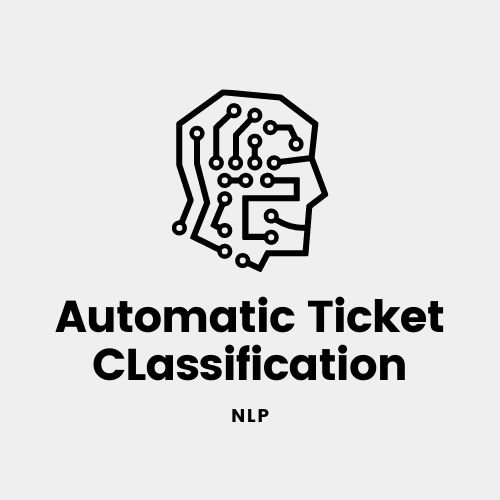

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports

import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

import email
import math
import os
import random
import re
import string
import unicodedata
from collections import Counter, defaultdict
from pathlib import Path
from pprint import pprint
from time import time

import contractions
import hjson
import jenkspy
import mailparser
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import spacy
import tensorflow
import xlrd
import yake
from bs4 import BeautifulSoup
from charset_normalizer import from_bytes
from ftfy import fix_text
from langdetect import DetectorFactory, detect_langs
from langdetect.lang_detect_exception import LangDetectException
from nltk.corpus import words
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from pandas.core.common import flatten
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

from utils.date_handler import DateHandler
from utils.email_handler import EmailHandler, email_regex
from utils.link_handler import LinkHandler
from utils.tel_handler import TelHandler
from utils.utils import clean_text, is_blank, is_not_blank, load_hjson
from wordcloud import STOPWORDS, WordCloud

tqdm.pandas()
%matplotlib inline
!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser'])

2021-10-02 13:54:05.700177: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
CONFIG_DIR = './config/config.hjson'
config = load_hjson(Path(CONFIG_DIR))

In [4]:
# reproducibility
seed = config['seed']
random.seed(seed)
tensorflow.random.set_seed(seed)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Import & Analyse the data.</span></strong></li>
</ul></h3>

In [5]:
# check encoding
with open('./data/input_data.xlsx', 'r') as fp:
    print(fp)

<_io.TextIOWrapper name='./data/input_data.xlsx' mode='r' encoding='cp1252'>


In [6]:
wb = xlrd.open_workbook('./data/input_data.xlsx', encoding_override='cp1252')  # use the input data's encoding to read properly
dataset = pd.read_excel(wb)
dataset.sample(7)

Short description  \
4415                             unable to login to vpn   
5279            telephony_software password has expired   
4303                         call for ecwtrjnq jpecxuty   
313             cannot access guest wifi sponsor portal   
6688                 setup time not calculated properly   
7564  probleme mit datenbank in EU_tool \hgrvubzo wg...   
6908                         access to engineering_tool   

                                            Description             Caller  \
4415  unable to login to vpn as the page stopped at ...  lckagtry xcrmzgli   
5279  my telephony_software password is getting expi...  rbozivdq gmlhrtvp   
4303                         call for ecwtrjnq jpecxuty  olckhmvx pcqobjnd   
313   receive "sponsor portal internal error" when a...  ctxwsvam vwgpjauf   
6688  email from kanchi (usa) on how confirmation ti...  entuakhp xrnhtdmk   
7564  probleme mit datenbank in EU_tool \hgrvubzo wg...  hgrvubzo wgyhktic   
6908                         access to engineering_tool  sjhrytwn yakzbslm   

     Assignment group  
4415            GRP_0  
5279            GRP_7  
4303            GRP_0  
313             GRP_0  
6688           GRP_41  
7564           GRP_24  
6908            GRP_0

In [7]:
dataset.shape  # very small dataset with only 8500 rows

(8500, 4)

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [9]:
# rename column names for convenience
dataset = dataset.rename(columns={
    "Short description": "short_description",
    "Description": "description",
    "Caller": "caller",
    "Assignment group": "group"
    })

In [10]:
np.unique(dataset.group), len(np.unique(dataset.group))  # 74 different functional groups

(array(['GRP_0', 'GRP_1', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
        'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
        'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
        'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_3', 'GRP_30',
        'GRP_31', 'GRP_32', 'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36',
        'GRP_37', 'GRP_38', 'GRP_39', 'GRP_4', 'GRP_40', 'GRP_41',
        'GRP_42', 'GRP_43', 'GRP_44', 'GRP_45', 'GRP_46', 'GRP_47',
        'GRP_48', 'GRP_49', 'GRP_5', 'GRP_50', 'GRP_51', 'GRP_52',
        'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56', 'GRP_57', 'GRP_58',
        'GRP_59', 'GRP_6', 'GRP_60', 'GRP_61', 'GRP_62', 'GRP_63',
        'GRP_64', 'GRP_65', 'GRP_66', 'GRP_67', 'GRP_68', 'GRP_69',
        'GRP_7', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73', 'GRP_8', 'GRP_9'],
       dtype=object),
 74)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Check for Incomplete Information</span></strong></li>
</ul></h3>

In [11]:
dataset.isna().sum()  # Few missing values

short_description    8
description          1
caller               0
group                0
dtype: int64

In [12]:
dataset[dataset.isna().any(axis=1)]  # check rows with missing values

short_description  \
2604                       NaN   
3383                       NaN   
3906                       NaN   
3910                       NaN   
3915                       NaN   
3921                       NaN   
3924                       NaN   
4341                       NaN   
4395  i am locked out of skype   

                                            description             caller  \
2604  \r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...  ohdrnswl rezuibdt   
3383  \r\n-connected to the user system using teamvi...  qftpazns fxpnytmk   
3906  -user unable  tologin to vpn.\r\n-connected to...  awpcmsey ctdiuqwe   
3910  -user unable  tologin to vpn.\r\n-connected to...  rhwsmefo tvphyura   
3915  -user unable  tologin to vpn.\r\n-connected to...  hxripljo efzounig   
3921  -user unable  tologin to vpn.\r\n-connected to...  cziadygo veiosxby   
3924  name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...  wvqgbdhm fwchqjor   
4341  \r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...  eqmuniov ehxkcbgj   
4395                                                NaN  viyglzfo ajtfzpkb   

       group  
2604  GRP_34  
3383   GRP_0  
3906   GRP_0  
3910   GRP_0  
3915   GRP_0  
3921   GRP_0  
3924   GRP_0  
4341   GRP_0  
4395   GRP_0

In [13]:
dataset.loc[dataset['description'].isna()]

short_description description             caller  group
4395  i am locked out of skype         NaN  viyglzfo ajtfzpkb  GRP_0

In [14]:
dataset.iloc[4395]

short_description    i am locked out of skype
description                               NaN
caller                      viyglzfo ajtfzpkb
group                                   GRP_0
Name: 4395, dtype: object

In [15]:
# imputing the short description by value in description and vice-versa
# However, If both columns were missing, we would have to drop the row
dataset.loc[dataset['description'].isna(), 'description']  = dataset.loc[dataset['description'].isna()].short_description

In [16]:
dataset.loc[dataset['short_description'].isna()]

short_description                                        description  \
2604               NaN  \r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...   
3383               NaN  \r\n-connected to the user system using teamvi...   
3906               NaN  -user unable  tologin to vpn.\r\n-connected to...   
3910               NaN  -user unable  tologin to vpn.\r\n-connected to...   
3915               NaN  -user unable  tologin to vpn.\r\n-connected to...   
3921               NaN  -user unable  tologin to vpn.\r\n-connected to...   
3924               NaN  name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...   
4341               NaN  \r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...   

                 caller   group  
2604  ohdrnswl rezuibdt  GRP_34  
3383  qftpazns fxpnytmk   GRP_0  
3906  awpcmsey ctdiuqwe   GRP_0  
3910  rhwsmefo tvphyura   GRP_0  
3915  hxripljo efzounig   GRP_0  
3921  cziadygo veiosxby   GRP_0  
3924  wvqgbdhm fwchqjor   GRP_0  
4341  eqmuniov ehxkcbgj   GRP_0

In [17]:
dataset.loc[dataset['short_description'].isna(), 'short_description']  = dataset.loc[dataset['short_description'].isna()].description

In [18]:
dataset.isna().sum()  # all missing values imputed

short_description    0
description          0
caller               0
group                0
dtype: int64

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Target Class Distribution</span></strong></li>
</ul></h3>

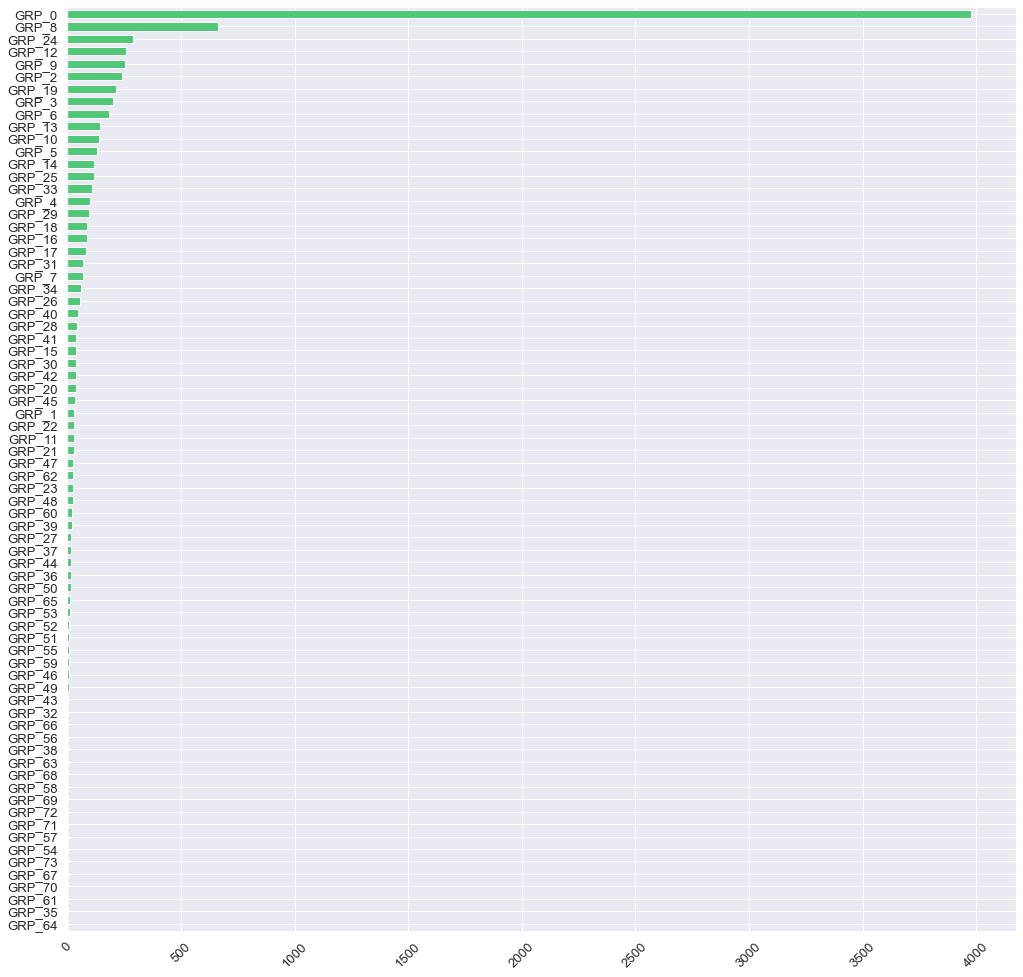

In [19]:
sns.set(font_scale=1.2)  # scale up font size
dataset.group.value_counts().sort_values(ascending=True).plot(kind='barh', width=0.65, figsize=(17, 17), color=config['green_rgb'])
plt.xticks(rotation=45)
plt.show()

In [20]:
dataset.group.value_counts().sort_values(ascending=False).tail(30)  # few classes with only single-digit datapoints

GRP_44    15
GRP_36    15
GRP_50    14
GRP_65    11
GRP_53    11
GRP_52     9
GRP_51     8
GRP_55     8
GRP_59     6
GRP_46     6
GRP_49     6
GRP_43     5
GRP_32     4
GRP_66     4
GRP_56     3
GRP_38     3
GRP_63     3
GRP_68     3
GRP_58     3
GRP_69     2
GRP_72     2
GRP_71     2
GRP_57     2
GRP_54     2
GRP_73     1
GRP_67     1
GRP_70     1
GRP_61     1
GRP_35     1
GRP_64     1
Name: group, dtype: int64

In [21]:
dataset[dataset.group == 'GRP_70']  # small groups have to merged into a separate "Others" category
dataset[dataset.group == 'GRP_70'].description.tolist()[0]

'an e-mail from  it training has email hints and tips #1.  under "create signature" it has a link "company formatheywting standard" that i am forbidden to see.\n615'

<h5><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>The target class distribution is heavily imbalanced as most calls are assinged to Group 0 and exluding this as well, we find an imabalanced dataset for the rest of the groups.
 </span></ul></h5>

In [22]:
temp = dataset.copy(deep=True)
temp.loc[temp["group"] != 'GRP_0', 'group'] = 'Other'
temp.loc[temp["group"] == 'GRP_0', "group"] = 'Group 0'

In [23]:
temp.group.value_counts()

Other      4524
Group 0    3976
Name: group, dtype: int64

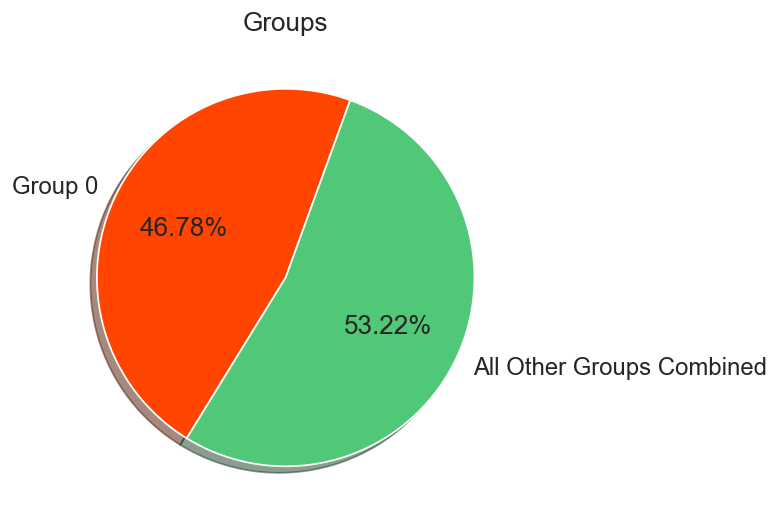

In [24]:
sns.set(font_scale=1.25)  # scale up font size

plt.figure(figsize=(5, 5), dpi=125)
group_0 = len(temp[temp['group'] == 'Group 0'])
others = len(temp[temp['group'] == 'Other'])

plt.pie(x=[group_0, others],
        explode=(0, 0),
        labels=['Group 0', 'All Other Groups Combined'],
        autopct='%1.2f%%',
        shadow=True,
        startangle=70,
        colors=[config['red_rgb'], config['green_rgb']])

fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.title('Groups')
plt.show()

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Choosing a Metric to benchmark model performance</span></strong></li>
</ul></h3>

* This is a multi-class classification problem, where the machine learning model will try to predict if each row is one of the 74 possibilities.
* The majority class is GRP_0, which occurs in 46.78% of the observations.

* The most common metrics for a multi-class classification problem are AUC, F1-score and accuracy.
* Accuracy is not suitable for an imbalanced classification problem. (Note that a model that always predicts GRP_0, will get an accuracy of 46.78%)
* We would choose F1-score if the majority class is more important than the smaller classes.
* We would choose AUC if we also care about the smaller classes.

#### As we want to be able to classify the tickets into all functional groups and functional groups are given equal importance, we choose AUC as the final metric to score model performance.

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Outlier Analysis</span></strong></li>
</ul></h3>

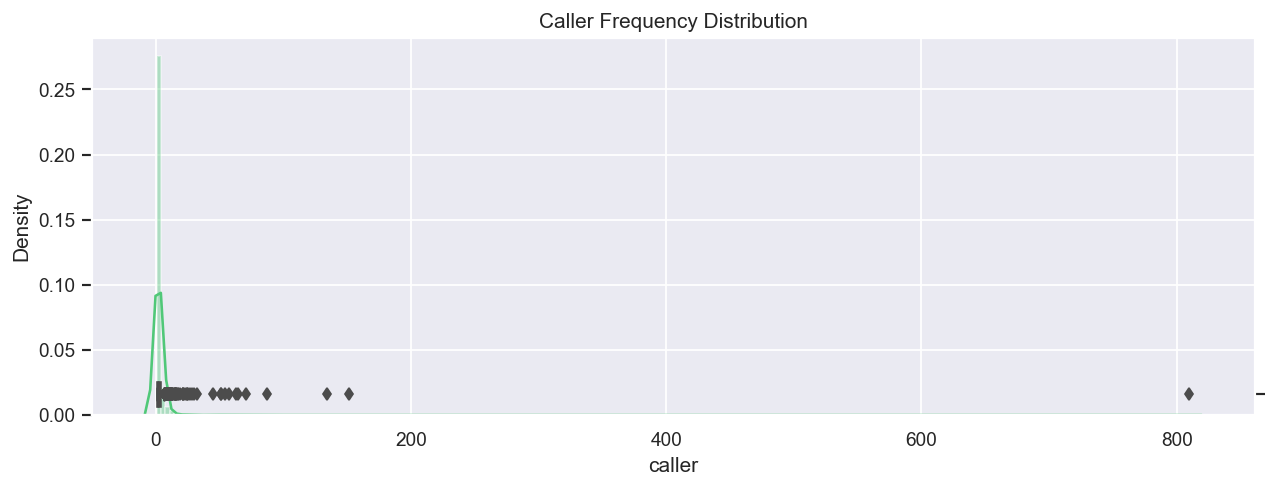

In [25]:
# plotting caller frequency counts
sns.set()
plt.figure(figsize=(12, 4), dpi=125)
ax = sns.distplot(dataset.caller.value_counts(), bins=250, kde=True, color=config['green_rgb'])
ax_ = ax.twinx()
sns.boxplot(dataset.caller.value_counts(), color=config['red_rgb'])
ax_.set(ylim=(-.7, 12))
plt.title('Caller Frequency Distribution')
plt.show()

In [26]:
dataset[dataset.caller == 'bpctwhsn kzqsbmtp'].group.value_counts()  # most frequent caller

GRP_8     362
GRP_9     153
GRP_5      96
GRP_6      89
GRP_10     60
GRP_60     16
GRP_12      8
GRP_45      7
GRP_1       6
GRP_13      4
GRP_18      3
GRP_47      2
GRP_57      1
GRP_14      1
GRP_29      1
GRP_44      1
Name: group, dtype: int64

In [27]:
dataset[dataset.caller == 'bpctwhsn kzqsbmtp']  # job failure alerts

short_description  \
47    job Job_1424 failed in job_scheduler at: 10/31...   
50    job mm_zscr0099_dly_merktc3 failed in job_sche...   
59    job mm_zscr0099_dly_merktc2 failed in job_sche...   
60    job Job_3181 failed in job_scheduler at: 10/31...   
67    job Job_1338 failed in job_scheduler at: 10/31...   
...                                                 ...   
7053  job Job_1387 failed in job_scheduler at: 08/18...   
7059  job Job_2063b failed in job_scheduler at: 08/1...   
7074  job HostName_1019fail failed in job_scheduler ...   
7076  job HostName_1019fail failed in job_scheduler ...   
7077  job HostName_1019fail failed in job_scheduler ...   

                                            description             caller  \
47    received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
50    received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
59    received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
60    received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
67    received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
...                                                 ...                ...   
7053  received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
7059  received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
7074  received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
7076  received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
7077  \r\n\r\nreceived from: monitoring_tool@company...  bpctwhsn kzqsbmtp   

       group  
47     GRP_6  
50     GRP_8  
59     GRP_8  
60     GRP_8  
67     GRP_9  
...      ...  
7053   GRP_9  
7059   GRP_6  
7074   GRP_8  
7076   GRP_8  
7077  GRP_60  

[810 rows x 4 columns]

In [28]:
def get_length(row):
    try:
        row['char_length'] = len(row.description)
        row['word_length'] = len(row.description.split())
        row['short_char_length'] = len(row.short_description)
        row['short_word_length'] = len(row.short_description.split())
    except Exception:  # assign 0 length to missing rows if any
        row['char_length'] = 0
        row['word_length'] = 0
        row['short_char_length'] = 0
        row['short_word_length'] = 0
    return row

dataset = dataset.progress_apply(get_length, axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8500/8500 [00:13<00:00, 614.04it/s]


In [29]:
dataset.sample(7)

short_description  \
1996                                erp SID_34 account    
2550      bex analyzer and bex designer is not working.   
1024          not able to open the existing hana report   
4411                    unable to install the gd&t font   
8333                                    password change   
5367  job Job_484 failed in job_scheduler at: 09/03/...   
3999                     ticket update - inplant_859150   

                                            description             caller  \
1996  \n\nreceived from: zuxcfonv.nyhpkrbe@gmail.com...  zuxcfonv nyhpkrbe   
2550      bex analyzer and bex designer is not working.  oncidblt ucewizyd   
1024          not able to open the existing hana report  rcbdyslq zuspjbtw   
4411  name: ovxwqybe gevzkrlp\nemail: ovxwqybe.gevzk...  ovxwqybe gevzkrlp   
8333  \r\n\r\nreceived from: orjcgtyz.worylufs@gmail...  orjcgtyz worylufs   
5367  received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
3999                     ticket update - inplant_859150  olckhmvx pcqobjnd   

       group  char_length  word_length  short_char_length  short_word_length  
1996   GRP_0          135           18                 19                  3  
2550  GRP_19           45            8                 45                  8  
1024   GRP_9           41            8                 41                  8  
4411   GRP_3          104           11                 31                  6  
8333   GRP_0          152           20                 15                  2  
5367   GRP_8          105           11                 61                  8  
3999   GRP_0           30            4                 30                  4

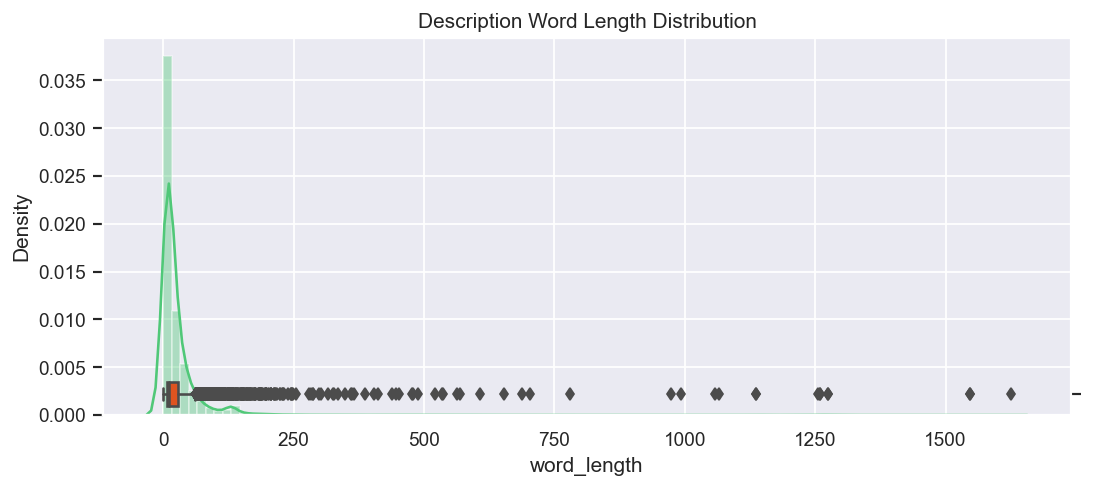

In [30]:
sns.set()
plt.figure(figsize=(10, 4), dpi=125)
ax = sns.distplot(dataset.word_length, bins=100, kde=True, color=config['green_rgb'])
ax_ = ax.twinx()
sns.boxplot(dataset.word_length, color=config['red_rgb'])
ax_.set(ylim=(-.7, 12))
plt.title('Description Word Length Distribution')
plt.show()

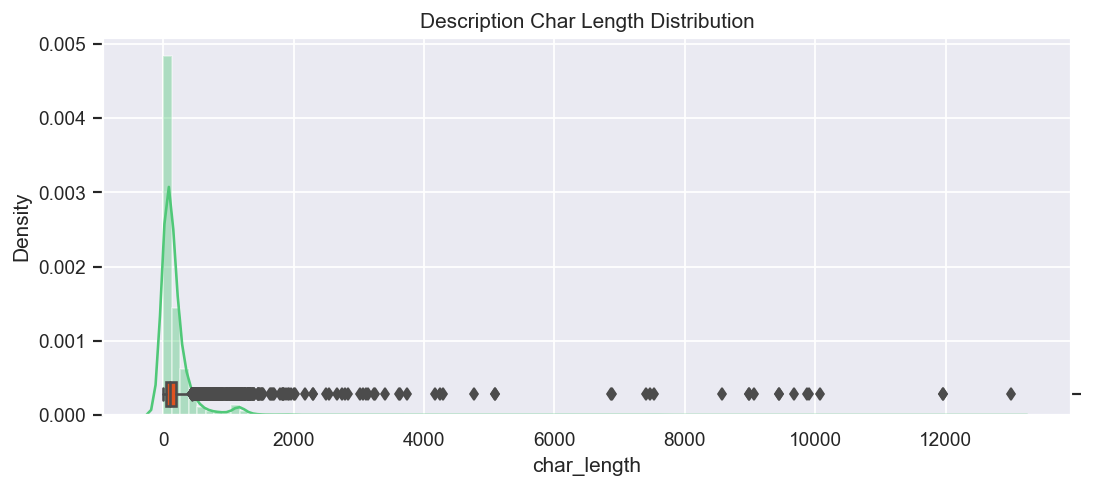

In [31]:
sns.set()
plt.figure(figsize=(10, 4), dpi=125)
ax = sns.distplot(dataset.char_length, bins=100, kde=True, color=config['green_rgb'])
ax_ = ax.twinx()
sns.boxplot(dataset.char_length, color=config['red_rgb'])
ax_.set(ylim=(-.7, 12))
plt.title('Description Char Length Distribution')
plt.show()

In [32]:
dataset[dataset.word_length == 0]  # empty description => imputing with the corresponding short_description

short_description description             caller  group  \
6371   authorization add/delete members    \r\n\r\n  hpmwliog kqtnfvrl  GRP_0   
7397                   browser issue :         \r\n  fgejnhux fnkymoht  GRP_0   

      char_length  word_length  short_char_length  short_word_length  
6371            5            0                 33                  3  
7397            2            0                 16                  3

In [33]:
dataset.loc[dataset.word_length == 0, 'description'] = dataset.loc[dataset.word_length == 0]['short_description']
dataset = dataset.progress_apply(get_length, axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8500/8500 [00:00<00:00, 10705.29it/s]


In [34]:
dataset[dataset.word_length == 0]  # cleaned

Empty DataFrame
Columns: [short_description, description, caller, group, char_length, word_length, short_char_length, short_word_length]
Index: []

In [35]:
dataset[dataset.char_length < 4]  # description 'the' holds no information => imputed with short_description

short_description description  \
1049  reset passwords for soldfnbq uhnbsvqd using pa...         the   
1054  reset passwords for fygrwuna gomcekzi using pa...         the   
1144  reset passwords for wvdxnkhf jirecvta using pa...         the   
1184  reset passwords for pxvjczdt kizsjfpq using pa...         the   
1292  reset passwords for cubdsrml znewqgop using pa...         the   
1476  reset passwords for bnoupaki cpeioxdz using pa...         the   
1558  reset passwords for usa feathers using passwor...         the   
1693  reset passwords for eglavnhx uprodleq using pa...         the   
1834  reset passwords for hybiaxlk lawptzir using pa...         the   
1850  reset passwords for fylrosuk kedgmiul using pa...         the   
1851  reset passwords for fylrosuk kedgmiul using pa...         the   
1860                                                  s           s   
2151  reset passwords for gjisfonb odwfhmze using pa...         the   
2532  reset passwords for qwsjptlo hnlasbed using pa...         the   
2533  reset passwords for qwsjptlo hnlasbed using pa...         the   
2553  reset passwords for bxeagsmt zrwdgsco using pa...         the   
2554  reset passwords for bxeagsmt zrwdgsco using pa...         the   
2572  reset passwords for prgewfly ndtfvple using pa...         the   
2602  reset passwords for wxdvjoct ckxwtoam using pa...         the   
2605  reset passwords for ytzpxhql ntfxgpms using pa...         the   
2749  reset passwords for fkuqjwit jgcsaqzi using pa...         the   
2788  reset passwords for hzmxwdrs tcbjyqps using pa...         the   
3000  reset passwords for knemilvx dvqtziya using pa...         the   
3432                                                dds         dss   
3447  reset passwords for qoybxkfh dwcmxuea using pa...         the   
3692  reset passwords for mvhcoqed konjdmwq using pa...         the   
3693  reset passwords for mvhcoqed konjdmwq using pa...         the   
4055  reset passwords for jerydwbn gdylnaue using pa...         the   
4065  reset passwords for dmexgspl mruzqhac using pa...         the   
4672  reset passwords for robhyertyj f duca using pa...         the   
4978  reset passwords for davidthd robankm using pas...         the   
4984  reset passwords for cubdsrml znewqgop using pa...         the   
4991  reset passwords for davidthd robankm using pas...         the   
5074  reset passwords for mafgtnik -0 using password...         the   
5077  reset passwords for cÃ©sar abreu rghkiriuytes ...         the   
5182  reset passwords for yolktfas fyoxqgvh using pa...         the   
5228  reset passwords for ugawcoye jcfqgviy using pa...         the   
5305  reset passwords for qgilmtyc gmscovxa using pa...         the   
5317  reset passwords for bxeagsmt zrwdgsco using pa...         the   
5482  reset passwords for qycgdfhz iqshzdru using pa...         the   
5708  reset passwords for bxeagsmt zrwdgsco using pa...         the   
5839  reset passwords for cpmaidhj elbaqmtp using pa...         the   
5884  reset passwords for bxeagsmt zrwdgsco using pa...         the   
6037  reset passwords for cesgrtar abgrtyreu using p...         the   
6058  reset passwords for bxeagsmt zrwdgsco using pa...         the   
6693  reset passwords for pzjelyxg vstyaouc using pa...         the   
6764  reset passwords for horeduca ogrhivnm using pa...         the   
6819  reset passwords for wvdxnkhf jirecvta using pa...         the   
6963  reset passwords for patrcja szpilewska using p...         the   
7131  reset passwords for ezrsdgfc hofgvwel using pa...         the   
7132  reset passwords for ezrsdgfc hofgvwel using pa...         the   
7169  reset passwords for andrdgrtew p taneghrty usi...         the   
7630  reset passwords for jcmxerol nbfyczqr using pa...         the   
7875  reset passwords for esias bosch using password...         the   
8059  reset passwords for wptbgchj jutpdcqf using pa...         the   
8092  reset passwords for prgthyuulla ramdntythanjes...       

In [36]:
dataset[dataset.description == 's']  # holds no actual information with just one letter, has to be dropped

short_description description             caller  group  char_length  \
1860                 s           s  gzjtweph mnslwfqv  GRP_0            1   

      word_length  short_char_length  short_word_length  
1860            1                  1                  1

In [37]:
# drop row with description: 's'
dataset.drop(dataset[dataset.description == 's'].index, inplace=True)
dataset = dataset.progress_apply(get_length, axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8499/8499 [00:00<00:00, 9871.10it/s]


In [38]:
# description 'the' holds no information => imputed with corresponding short_description
dataset.loc[dataset.description == 'the', 'description'] = dataset.loc[dataset.description == 'the']['short_description']
dataset = dataset.progress_apply(get_length, axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8499/8499 [00:00<00:00, 10966.45it/s]


In [39]:
# Single Word descriptions
dataset[dataset.word_length == 1].shape

(41, 8)

In [40]:
# dataset[dataset.word_length == 1].to_csv('./data/Single_Word_Descriptions.csv')
dataset[dataset.word_length == 1].sample(20)  # these have to be cleaned up and imputed later on

short_description  \
6106                                 ç”µè„‘ä¸èƒ½å¼€æœº   
4505   request to reset microsoft online services pa...   
608   etiketten drucker im bereich endkontrolle germ...   
4503                        ç”¨å‹å®šæœŸå¤‡ä»½ä¸æˆåŠŸ   
3432                                                dds   
5146                                 walkmeåŠ è½½æ•…éšœ   
5761                                 ä¸»æœºä¸èƒ½å¼€å¯   
4569  i am not able to connect to my regular printer...   
618                                    outlookæ‰“ä¸å¼€   
5311                       ç³»ç»Ÿæ•…éšœï¼Œå¯åŠ¨è“å±.   
1399  i cant see my archived emails in outlook.  i a...   
1955                     æœ‰ä¸€ä¸ªé“¾æŽ¥æ–‡ä»¶æ‰“ä¸å¼€   
4501                  åˆ¶ç²‰ä¸‰æ¥¼æŽ§åˆ¶å®¤ç”µè„‘æ•…éšœ   
3738                                       ç”µè¯æ•…éšœ   
5147                                 ç”µè„‘å¼€æœºæ•…éšœ   
1081                                 ç”¨å‹è½¯ä»¶é—®é¢˜   
5149                                       å¼€ä¸äº†æœº   
6253  in the inbox always show there are several ema...   
416   reset the password for prgewfly ndtfvple on er...   
1452            è€ƒå‹¤ç³»ç»Ÿè¿›ä¸åŽ»è¯·å¤„ç†è°¢è°¢ï¼   

                                            description             caller  \
6106                     æ—©ä¸Šä¸Šç­ç”µè„‘æ‰“ä¸å¼€ã€‚  mzerdtop xnlytczj   
4505                                      \r\n\r\nkind   rcfwnpbi kvhedyrc   
608                                   funktionsstÃ¶rung  tzmewbdv zjbuwmkn   
4503  æœåŠ¡å™¨ç«¯ç”¨å‹ç³»ç»Ÿæœ€è¿‘åŠä¸ªæœˆæ—¥å¤‡ä...  igdnsjhz awnftgev   
3432                                                dss  onctqhsg cpahzsle   
5146  walkmeä¸‹è½½å®‰è£…åŽï¼ŒæŒ‰é’®ä¸èƒ½åœ¨æµè§ˆå...  whflryeb fatgdzhq   
5761  ä¸»æœºä¸èƒ½å¼€å¯ï¼Œç”µæºç¯æ­£å¸¸ï¼Œä¸»æœºé...  cpdilmjx jwsqpiac   
4569                                             x5380   koiapqbg teyldpkw   
618   æ‰“å¼€outlookæ—¶ï¼Œæ˜¾ç¤ºoutlook.ostæ–‡ä»¶é”™è...  qayozbcd vwglmpjq   
5311                      ç³»ç»Ÿæ•…éšœï¼Œå¯åŠ¨è“å±.   lhkqbmna ekhtivsd   
1399                                            outlook  koiapqbg teyldpkw   
1955      æœ‰ä¸€é“¾æŽ¥æ–‡ä»¶æ‰“ä¸å¼€ï¼Œæç¤ºç‰ˆæœ¬ä½Ž  qsfcxzel quwykhno   
4501  åˆ¶ç²‰ä¸‰æ¥¼æŽ§åˆ¶å®¤ç”µè„‘ä¸èƒ½å¼€å¯ï¼Œç”µæ...  agyvbnwz mxsonkdc   
3738                é“¸æ£’è½¦é—´ç”µè¯æ•…éšœï¼Œ39523850  sbkhjigv pbvlfcse   
5147  åŽŸææ–™ä»“åº“ç”µè„‘å¼€æœºè“å±ï¼Œä¸»æœºé¢æ...  ycjxrsba ehftdorm   
1081  æ‰“å¼€å·²å…³é—­çš„é”€å”®è®¢å•æ—¶ï¼Œæ˜¾ç¤º"ä¸...  bwstnmjh yqumwrsk   
5149               å¼€ä¸äº†æœºï¼Œæ˜¾ç¤ºç³»ç»Ÿåäº†ã€‚  kclhqspo xvugztyc   
6253                                              +86    mqbxwpfn uclrqfxa   
416                                           completed  prgewfly ndtfvple   
1452            è€ƒå‹¤ç³»ç»Ÿè¿›ä¸åŽ»è¯·å¤„ç†è°¢è°¢ï¼  spgdcvhb ocagnpmj   

       group  char_length  word_length  short_char_length  short_word_length  
6106  GRP_30           30            1                 18                  1  
4505   GRP_0            9            1                 84                  9  
608   GRP_33           17            1                 56                  7  
4503  GRP_48           54            1                 27                  1  
3432   GRP_0            3            1                  3                  1  
5146  GRP_48           60            1                 18                  2  
5761  GRP_48           71            1                 18                  1  
4569   GRP_0            6            1                 84                 16  
618    GRP_0           72            1                 16                  1  
5311  GRP_31           29            1                 28                  1  
1399   GRP_0            7            1                129                 22  
1955  GRP_30           45            1                 30                  1  
4501  GRP_48           72            1                 33                  1  
3738  GRP_48           35            1               

In [41]:
dataset[dataset.word_length == 2].sample(20)

short_description  \
1449                                    account locked.   
5973                                   outlook freezes.   
3400                                    account locked.   
6843  kpm time sheet is not submitting. please resol...   
1761                                    outlook freezes   
3096                             unable to login to erp   
7034                                         blank call   
4487                       vpn è¿žæŽ¥åŽè‡ªåŠ¨æ–­å¼€ã€‚   
7378                                     password reset   
7504                      collaboration_platform issue    
3172                                     password reset   
5754         skype ä¸èƒ½ç™»å½•ï¼Œæç¤ºè¯ä¹¦é”™è¯¯ã€‚   
4071                           abend batch job:Job_1391   
2039                                     general query    
4433                                     account unlock   
2980  hp2çƒ­åŽ‹ç‚‰æ•°æ®ä¼ è¾“å¡ï¼Œæ•°æ®æ›´æ–°ä¸å...   
7307  å®žä¹ ç”Ÿç™»å½•office365ä¸‹è½½é‚®ä»¶é™„ä»¶æ—¶æ...   
5123  collaboration_platform é‡Œé¢æ‰“å¼€"æŸ¥çœ‹æˆ‘ç...   
7314                     åˆ¶ç²‰ç”µè„‘ç”µæºçº¿ç­‰æŸå   
1711                                       å¼€æœºé»‘å±   

                                            description             caller  \
1449                                    account locked.  dyqekzuc djhznybt   
5973                                   outlook freezes.  rwhavckz drvxyihj   
3400                                    account locked.  vyjmlain hvjbmdgi   
6843                              employee id-210667827  kdfnaytr pudqfmtc   
1761                                   outlook freezes.  techruxg wasrvkuz   
3096                                 misplaced password  uaclgmeq hyxzmwdi   
7034                                         blank call  fumkcsji sarmtlhy   
4487  vpn è¿žæŽ¥åŽè‡ªåŠ¨æ–­å¼€ï¼Œæç¤ºè°ƒåˆ¶è§£è°ƒ...  tmufgokq qtzavows   
7378                                     password reset  kauozcir jlyqxise   
7504                      collaboration_platform issue   utdlmzyb dvfpraeg   
3172                                     password reset  insbceoa czgpyrtb   
5754         skype ä¸èƒ½ç™»å½•ï¼Œæç¤ºè¯ä¹¦é”™è¯¯ã€‚  qekyowtv qdjixvkh   
4071                                  job name:Job_1391  oldrctiu bxurpsyi   
2039                                     general query   zfliqpxm dgfvaqlh   
4433                                     account unlock  ykrteqjw lvxqjydf   
2980  hp2çƒ­åŽ‹ç‚‰æ•°æ®ä¼ è¾“å¡ï¼Œæ•°æ®æ›´æ–°ä¸å...  basqoyjx frvwhbse   
7307  å®žä¹ ç”Ÿç™»å½•office365ä¸‹è½½é‚®ä»¶é™„ä»¶æ—¶æ...  kyagjxdh dmtjpbnz   
5123  collaboration_platform é‡Œé¢æ‰“å¼€"æŸ¥çœ‹æˆ‘ç...  lkrfndev kztlojin   
7314  åˆ¶ç²‰ä¸‰æ¥¼æŽ§åˆ¶å®¤å†…ç”µè„‘ç”µæºçº¿ã€ç½‘ç...  agyvbnwz mxsonkdc   
1711            ç”µè„‘å¯åŠ¨åŽé»‘å±ï¼Œä¸»æœºæ— æŠ¥è­¦  ofiglcaq hvcqtzel   

       group  char_length  word_length  short_char_length  short_word_length  
1449   GRP_0           15            2                 15                  2  
5973   GRP_0           16            2                 16                  2  
3400   GRP_0           15            2                 15                  2  
6843   GRP_0           21            2                 80                 14  
1761   GRP_0           16            2                 15                  2  
3096   GRP_0           18            2                 22                  5  
7034   GRP_0           10            2                 10                  2  
4487  GRP_31           61            2                 28                  2  
7378   GRP_0           14            2                 14                  2  
7504   GRP_0           29            2                 29                  2  
3172   GRP_0           14            2                 14                  2  
5754  GRP_31           42            2                 42                  2  
4071   GRP_8           17            2                 24                  3  
2039   GRP_0           14            2               

In [42]:
dataset[dataset.short_word_length == 0]  # all have short descriptions

Empty DataFrame
Columns: [short_description, description, caller, group, char_length, word_length, short_char_length, short_word_length]
Index: []

In [43]:
dataset[dataset.short_char_length < 3]

short_description                                        description  \
3529                PR  create a purchase requisition with purchasing ...   

                 caller   group  char_length  word_length  short_char_length  \
3529  ejvkzobl yijgokrn  GRP_29          201           31                  2   

      short_word_length  
3529                  1

In [44]:
dataset[dataset.char_length < 4]  

short_description description             caller  group  char_length  \
3432               dds         dss  onctqhsg cpahzsle  GRP_0            3   

      word_length  short_char_length  short_word_length  
3432            1                  3                  1

In [45]:
dataset[dataset.word_length > 800]  # security incident logs

short_description  \
3530  security incidents - ( #in33944691 ) : possibl...   
3965  security incidents - ( #in33809307 ) : possibl...   
4087  security incidents - ( sw #in33895560 ) : mage...   
4089  security incidents - ( sw #in33895560 ) : mage...   
5092  security incidents - ( #in33578632) : suspicio...   
5433  security incidents - ( #in33765965 ) : possibl...   
7345  security incidents - ( sw #in33501789 ) : broa...   
7647  security incidents - ( #in33578632) : suspicio...   
7982  security incidents - ( dsw #in33390850 ) : sus...   
7984  security incidents - ( dsw #in33390850 ) : sus...   
7989  security incidents - ( dsw #in33407676 ) : tra...   
7995  security incidents - ( dsw #in33407676 ) : tra...   
7997  security incidents - ( sw #in33544563 ) : poss...   
8002  security incidents - ( sw #in33544563 ) : poss...   

                                            description             caller  \
3530  source ip: 195.272.28.222\nsource port: 80\nso...  gzhapcld fdigznbk   
3965  source ip :195.22.28.222 \nsystem name :androi...  gzhapcld fdigznbk   
4087  source ip : 172.20.10.37 , 208.211.136.158\nsy...  ugyothfz ugrmkdhx   
4089  source ip : 172.20.10.37 , 208.211.136.158\nsy...  ugyothfz ugrmkdhx   
5092  source ip: 29.26.13.3095\r\nsource hostname: H...  gzhapcld fdigznbk   
5433  source ip :10.40.6.221\nsystem name :rqxl85172...  gzhapcld fdigznbk   
7345  we are seeing activity indicating the host at ...  ugyothfz ugrmkdhx   
7647  source ip :\r\nsystem name :\r\nuser  name:\r\...  gzhapcld fdigznbk   
7982  source ip : 78.83.16.293\nsystem name : HostNa...  ugyothfz ugrmkdhx   
7984  source ip : 78.83.16.293\r\nsystem name : Host...  ugyothfz ugrmkdhx   
7989  source ip : 61.01.52.02617\r\nsystem name : lp...  ugyothfz ugrmkdhx   
7995  source ip : 61.01.52.02617\r\nsystem name : lp...  ugyothfz ugrmkdhx   
7997  source ip : 45.25.35.0499\nsystem name : lpal9...  ugyothfz ugrmkdhx   
8002  source ip : 45.25.35.0499\r\nsystem name : lpa...  ugyothfz ugrmkdhx   

       group  char_length  word_length  short_char_length  short_word_length  
3530   GRP_2         7524          974                111                 17  
3965   GRP_2         8988         1255                116                 17  
4087  GRP_39        11968         1547                 63                 11  
4089   GRP_2        11968         1547                 63                 11  
5092   GRP_3         9063         1066                 92                 11  
5433   GRP_2         8575         1057                 83                 13  
7345   GRP_2        13001         1625                102                 14  
7647   GRP_2         8991          993                 92                 11  
7982   GRP_2         9881         1137                118                 17  
7984  GRP_12        10077         1137                118                 17  
7989   GRP_2         9440         1275                109                 18  
7995  GRP_62         9440         1275                109                 18  
7997   GRP_2         9678         1260                107                 16  
8002  GRP_62         9912         1260                107                 16

In [46]:
dataset[dataset.word_length > 200][dataset.word_length < 800]

short_description  \
238   erp pi and msd crm connectivity issue- serirtc...   
239                 printer problem / issue information   
981   employment status - new non-employee ycgkinov ...   
1175  bitte das iphone-6 001 freischalten fÃ¼r mail-...   
1179  media server disconnect lpapr952(south_amerirt...   
1577  the printer is defaulting to the usa printer f...   
1696  mm:pur_req_ko assign for user: yeyhtung kimthy...   
1812  sales orders are not updating with correct del...   
1855  printer problem / issue information -- zebra l...   
2082        printing language sa38 (reporting rfumsv00)   
2370  update inwarehouse_tool documents from list fo...   
2445  vh 27 - werk germany - fehlende druckauftrÃ¤ge...   
2492  printing request - request transaction print t...   
2741  i have lost my access to reporting_tool in crm...   
2879                           mobile device activation   
2978  security incidents - ( #in33987594) : 29866 vi...   
3097  security incidents - ( #in33976733) : suspicio...   
3098  security incidents - ( #in33984033) : internal...   
3165  partial confirmation info sent to erp but mach...   
3325                                            it help   
3382                                       support with   
3532  security incidents - ( #in33944327) :possible ...   
3705  security incidents - ( #in33932723 ) : possibl...   
3706  security incidents - ( #in33924718 ) : possibl...   
3718                     re: need a little help--please   
3961  security incidents - ( #in33805815) : possible...   
4382                printer problem / issue information   
4730  security incidents - (  #in33847938) : possibl...   
4825   incident #in33541962 - phishing form submit -...   
4853         bahdqrcs xvgzdtqj's onbankrding experience   
4886  security incidents - ( #in33826812 ) : possibl...   
4893  security incidents - ( #in33826812 ) : possibl...   
5072  erp-step interface programdnty not sending all...   
5204  employment status - three new non-employee [en...   
5394                                              hana    
5485               printer problem / issue information    
5503                                     dsw in22210104   
5504   incident #in33541962 - phishing form submit -...   
5506                                     dsw in22457494   
5507  possible vulnerability scan from host.my-tss.c...   
5697                printer problem / issue information   
5787  windows asks to install driver and then won't ...   
6017     open order schedule lines_p2016-08-28-22-03-54   
6734  security incidents - ( dsw incident no ) : sus...   
6888  security incidents - (#in33655554) : errata se...   
6931  '51551 vid67965 microsoft windows httpsys rce ...   
7163  symantec endpoint encryption (see) agent roll ...   
7331  security incidents - ( #in33505432 ) : repeat ...   
7338  security incidents - ( #in33505432 ) : repeat ...   
7433  zpdist_programdnty not allowing to distribute ...   
7553                    wifi slow speed-company (apac)    
7981  as per inc1530176::security incidents - (in335...   
7987  security incidents - (in33536629) : possible t...   
7991  as per inc1530161::security incidents - ( in33...   
7996  security incidents - ( in33490582 ) : suspicio...   
8160                                  release of device   
8232  stepfhryhan needs access to below collaboratio...   
8339     unlock account  email  in cell phone the users   

                                            description             caller  \
238   hi all\n\nwe have a connectivity issue between...  kgytujhe bonhwzrx   
239   please complete all required questions below. ...  dzjxrkae grqczsmx   
981   *page down to ensure that all required data fi...  lfikjasz tjbqcmvl   
1175  \n\nreceived from: rtnyumbg.yzemkhbq@gmail.com...  rtnyumbg yzemkhbq   
1179  received below email from inin tried to ping t...  jloygrwh acvztedi   
1577  from: kryuisti turleythy \nsent: wednesday, oc...  hybiaxlk lawptzir   
1696  mm:p

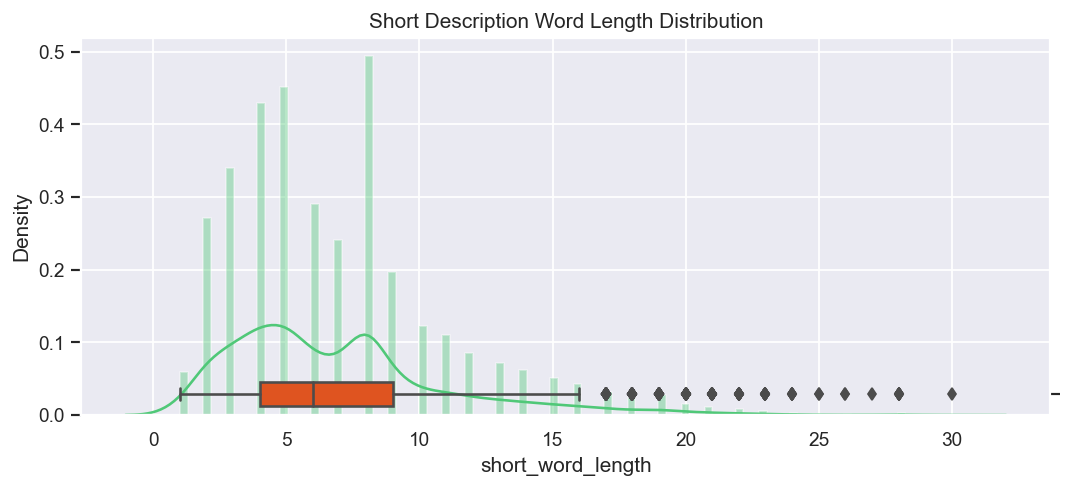

In [47]:
sns.set()
plt.figure(figsize=(10, 4), dpi=125)
ax = sns.distplot(dataset.short_word_length, bins=100, kde=True, color=config['green_rgb'])
ax_ = ax.twinx()
sns.boxplot(dataset.short_word_length, color=config['red_rgb'])
ax_.set(ylim=(-.7, 12))
plt.title('Short Description Word Length Distribution')
plt.show()

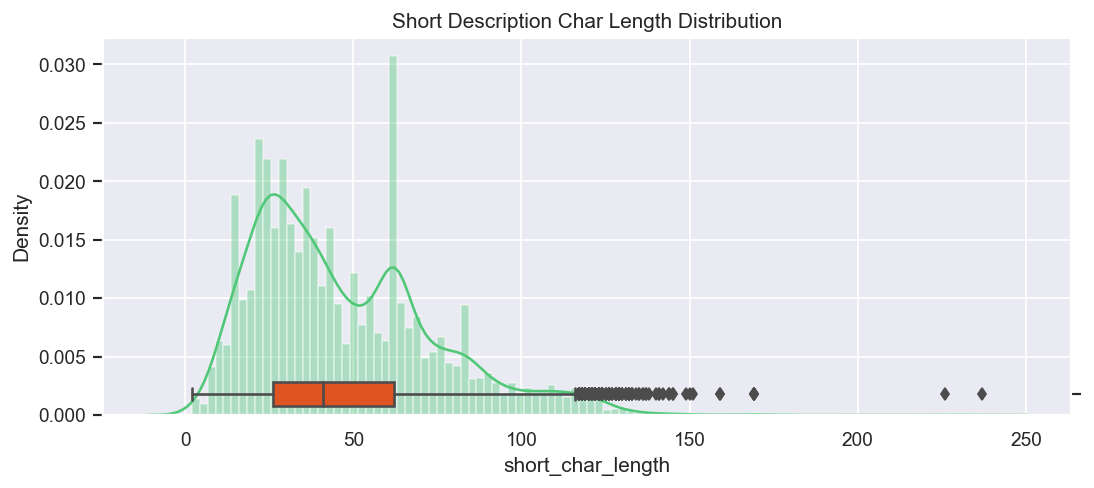

In [48]:
sns.set()
plt.figure(figsize=(10, 4), dpi=125)
ax = sns.distplot(dataset.short_char_length, bins=100, kde=True, color=config['green_rgb'])
ax_ = ax.twinx()
sns.boxplot(dataset.short_char_length, color=config['red_rgb'])
ax_.set(ylim=(-.7, 12))
plt.title('Short Description Char Length Distribution')
plt.show()

In [49]:
dataset.describe()

char_length  word_length  short_char_length  short_word_length
count   8499.000000  8499.000000        8499.000000        8499.000000
mean     204.595246    27.331804          47.386751           6.951759
std      519.530803    65.026307          27.323700           4.158631
min        3.000000     1.000000           2.000000           1.000000
25%       42.000000     6.000000          26.000000           4.000000
50%      106.000000    11.000000          41.000000           6.000000
75%      201.000000    28.000000          62.000000           9.000000
max    13001.000000  1625.000000         237.000000          30.000000

<h5><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Most descriptions have between 6 and 28 words long with median at 41 (106 characters) and mean at 27.2 with relatively few outliers ranging till 1625 words!<br>
    <li>Most Short descriptions have between 4 and 9 words long with median at 6 (41 characters) and mean at 6.92 with relatively few outliers ranging till 28 words.<br>
 </span></ul></h5>

In [50]:
def clean_nonsensible_outliers():
    # impute the zero length description with corresponding short description
    dataset.loc[dataset.word_length == 0, 'description'] = dataset.loc[dataset.word_length == 0]['short_description']
     # drop row with description: 's'
    dataset.drop(dataset[dataset.description == 's'].index, inplace=True)
    # description 'the' holds no information => imputed with corresponding short_description
    dataset.loc[dataset.description == 'the', 'description'] = dataset.loc[dataset.description == 'the']['short_description']

# clean_nonsensible_outliers()

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Fix Text Encoding</span></strong></li>
</ul></h3>

In [51]:
dataset[dataset.word_length == 1].sample(20)

short_description  \
1178                              ç”µè¯æœºæ²¡æœ‰å£°éŸ³   
5147                                 ç”µè„‘å¼€æœºæ•…éšœ   
276   outlookæ”¶åˆ°ç®±ä¸­folderå˜ä¸ºæ¯å¤©ä¸€ä¸ªfol...   
5303      æŠ¥ç¨Žç”µè„‘ä¸èƒ½è”ç½‘ï¼Œè®©è´ºæ­£å¹³ä¼‘ã€‚   
618                                    outlookæ‰“ä¸å¼€   
2915             websites not loading on company center   
5891                  vpnä¸èƒ½ä½¿ç”¨ï¼Œè¯·è½¬ç»™å°è´º   
4505   request to reset microsoft online services pa...   
2267  urgent help required- outlook to crm mfg_toolt...   
1704                                    è´¦æˆ·è¢«é”å®š   
5146                                 walkmeåŠ è½½æ•…éšœ   
5491                    é›»è…¦å‡ºç¾è—å±,ç„¡æ³•é–‹æ©Ÿ   
1081                                 ç”¨å‹è½¯ä»¶é—®é¢˜   
5833  new cpp id can not request initiative.  see im...   
4503                        ç”¨å‹å®šæœŸå¤‡ä»½ä¸æˆåŠŸ   
1954                        ç¬”è®°æœ¬é‡æ–°è£…ä¸‹ç³»ç»Ÿ   
7969               å®¢æˆ·æä¾›çš„åœ¨çº¿ç³»ç»Ÿæ‰“ä¸å¼€   
4098  ç”µè„‘æ„å¤–è¿›æ°´ï¼Œå¸®åŠ©å¤„ç†ï¼è¯·äº¤å°è...   
5762       æ‰“å¼€office 2013æ˜¾ç¤ºæ˜¯æœªç»æŽˆæƒäº§å“   
4569  i am not able to connect to my regular printer...   

                                            description             caller  \
1178                              ç”µè¯æœºæ²¡æœ‰å£°éŸ³  cyjlqdwm kywiuosn   
5147  åŽŸææ–™ä»“åº“ç”µè„‘å¼€æœºè“å±ï¼Œä¸»æœºé¢æ...  ycjxrsba ehftdorm   
276   outlookæ”¶åˆ°ç®±ä¸­folderå˜ä¸ºæ¯å¤©ä¸€ä¸ªfol...  bxfdkiol mdqlszvc   
5303      æŠ¥ç¨Žç”µè„‘ä¸èƒ½è”ç½‘ï¼Œè®©è´ºæ­£å¹³ä¼‘ã€‚  hlrmufzx qcdzierm   
618   æ‰“å¼€outlookæ—¶ï¼Œæ˜¾ç¤ºoutlook.ostæ–‡ä»¶é”™è...  qayozbcd vwglmpjq   
2915                          companycenter.company.com  qcfmxgid jvxanwre   
5891                  vpnä¸èƒ½ä½¿ç”¨ï¼Œè¯·è½¬ç»™å°è´º  ehfvwltg eakjbtoi   
4505                                      \r\n\r\nkind   rcfwnpbi kvhedyrc   
2267                                           contact   gonflcmq wmptisvz   
1704                  ç”¨æˆ·è´¦æˆ·é”å®šï¼Œè¯·æ±‚è§£é”  yvscpgax wdfxytzu   
5146  walkmeä¸‹è½½å®‰è£…åŽï¼ŒæŒ‰é’®ä¸èƒ½åœ¨æµè§ˆå...  whflryeb fatgdzhq   
5491  é€£vpnæ™‚,ç„¡æ³•é€£ä¸Šå¾Œ,é‡è©¦å¾Œ,çªç„¶å‡ºç...  zhpwcdea cboefuis   
1081  æ‰“å¼€å·²å…³é—­çš„é”€å”®è®¢å•æ—¶ï¼Œæ˜¾ç¤º"ä¸...  bwstnmjh yqumwrsk   
5833                                       cphlme01\r\n  pfzxecbo ptygkvzl   
4503  æœåŠ¡å™¨ç«¯ç”¨å‹ç³»ç»Ÿæœ€è¿‘åŠä¸ªæœˆæ—¥å¤‡ä...  igdnsjhz awnftgev   
1954               æŠŠæˆ‘çš„ç¬”è®°æœ¬é‡æ–°è£…ä¸‹ç³»ç»Ÿ  xjvubmlq vyamhjip   
7969  å®¢æˆ·æä¾›çš„åœ¨çº¿é€è´§å•ç”Ÿæˆç³»ç»Ÿæ‰“ä...  fupikdoa gjkytoeh   
4098  ç”µè„‘æ„å¤–è¿›æ°´ï¼Œå¸®åŠ©å¤„ç†ï¼è¯·äº¤å°è...  pvfclkmn gebyipwr   
5762  æ‰“å¼€outlookã€pptæ˜¾ç¤ºæ˜¯æœªç»æŽˆæƒäº§å“...  hbvwqine eakqyovu   
4569                                             x5380   koiapqbg teyldpkw   

       group  char_length  word_length  short_char_length  short_word_length  
1178  GRP_30           21            1                 21                  1  
5147  GRP_48           68            1                 18                  1  
276   GRP_30           73            1                 73                  1  
5303  GRP_30           45            1                 45                  1  
618    GRP_0           72            1                 16                  1  
2915   GRP_0           25            1                 38                  6  
5891   GRP_0           33            1                 33                  1  
4505   GRP_0            9            1                 84                  9  
2267   GRP_0            8            1                 56                  8  
1704  GRP_48           33            1                 15                  1  
5146  GRP_48           60            1                 18                  2  
5491  GRP_31           67            1                 31                  1  
1081  GRP_48          101            1                 18                  1  
5833  GRP_21           10            1               

In [52]:
def fix_text_encoding(row):
    row['description'] = fix_text(row.description)
    row['short_description'] = fix_text(row.short_description)
    return row

dataset = dataset.progress_apply(fix_text_encoding, axis=1)
dataset[dataset.word_length == 1].sample(20)  # translated to proper unicode text in chineese

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8499/8499 [00:02<00:00, 3241.37it/s]


short_description  \
1452                                      考勤系统进不去请处理谢谢!   
4501                                        制粉三楼控制室电脑故障   
1955                                         有一个链接文件打不开   
5149                                               开不了机   
2915             websites not loading on company center   
8266                                   erp无法进行采购(转给贺正平)   
7302                                         skype会议时不去   
6106                                             电脑不能开机   
6253  in the inbox always show there are several ema...   
5891                                      vpn不能使用,请转给小贺   
415   reset passwords for prgewfly ndtfvple using pa...   
4505   request to reset microsoft online services pa...   
3738                                               电话故障   
5146                                         walkme加载故障   
4569  i am not able to connect to my regular printer...   
1081                                             用友软件问题   
618                                          outlook打不开   
3432                                                dds   
2267  urgent help required- outlook to crm mfg_toolt...   
4098                                电脑意外进水,帮助处理!请交小贺,谢谢   

                               description             caller   group  \
1452                         考勤系统进不去请处理谢谢!  spgdcvhb ocagnpmj  GRP_30   
4501              制粉三楼控制室电脑不能开启,电源指示灯桔色频闪。  agyvbnwz mxsonkdc  GRP_48   
1955                       有一链接文件打不开,提示版本低  qsfcxzel quwykhno  GRP_30   
5149                          开不了机,显示系统坏了。  kclhqspo xvugztyc  GRP_30   
2915             companycenter.company.com  qcfmxgid jvxanwre   GRP_0   
8266  进行采购时显示"找不到员工1111154833的数据,请通知系统管理员"  kyagjxdh dmtjpbnz  GRP_30   
7302                    skype会议从邮箱里的链接进不去。  rekpvblc ufysatml  GRP_30   
6106                            早上上班电脑打不开。  mzerdtop xnlytczj  GRP_30   
6253                                 +86    mqbxwpfn uclrqfxa   GRP_0   
5891                         vpn不能使用,请转给小贺  ehfvwltg eakjbtoi   GRP_0   
415                               complete  prgewfly ndtfvple  GRP_17   
4505                             \n\nkind   rcfwnpbi kvhedyrc   GRP_0   
3738                     铸棒车间电话故障,39523850  sbkhjigv pbvlfcse  GRP_48   
5146              walkme下载安装后,按钮不能在浏览器界面显现  whflryeb fatgdzhq  GRP_48   
4569                                x5380   koiapqbg teyldpkw   GRP_0   
1081   打开已关闭的销售订单时,显示"不能在手动或分布事物方式下创建新的链接"  bwstnmjh yqumwrsk  GRP_48   
618   打开outlook时,显示outlook.ost文件错误,程序自动关闭。  qayozbcd vwglmpjq   GRP_0   
3432                                   dss  onctqhsg cpahzsle   GRP_0   
2267                              contact   gonflcmq wmptisvz   GRP_0   
4098                   电脑意外进水,帮助处理!请交小贺,谢谢  pvfclkmn gebyipwr  GRP_30   

      char_length  word_length  short_char_length  short_word_length  
1452           39            1                 39                  1  
4501           72            1                 33                  1  
1955           45            1                 30                  1  
5149           36            1                 12                  1  
2915           25            1                 38                  6  
8266           84            1                 42                  2  
7302           44            1                 20                  1  
6106           30            1                 18                  1  
6253            5            1                 94                 19  
5891           33            1                 33                  1  
415             8            1                 84                  9  
4505            9            1                 84                  9  
3738           35            1                 12                  1  
5146           60            1                 18                  2  
4569            6            1                 84                 16  
1081          101            1                 18                  1  
618            72            1                 16        

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Word Frequency Distributions & WordClouds</span></strong></li>
</ul></h3>

In [53]:
# top 50 most frequent words in text
top_N = config['top_n']

words = (dataset.description.str.cat(sep=' ').split())
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

In [54]:
rslt[:top_N].transpose()

Word         to   the    in    is  from:   and  received     i    on   for  \
Frequency  6296  6254  3172  2670   2499  2384      2354  2244  1977  1946   

Word       ...  can   we   as  access  when  site   am  account  ticket  error  
Frequency  ...  684  669  665     664   656   654  645      627     605    577  

[1 rows x 50 columns]

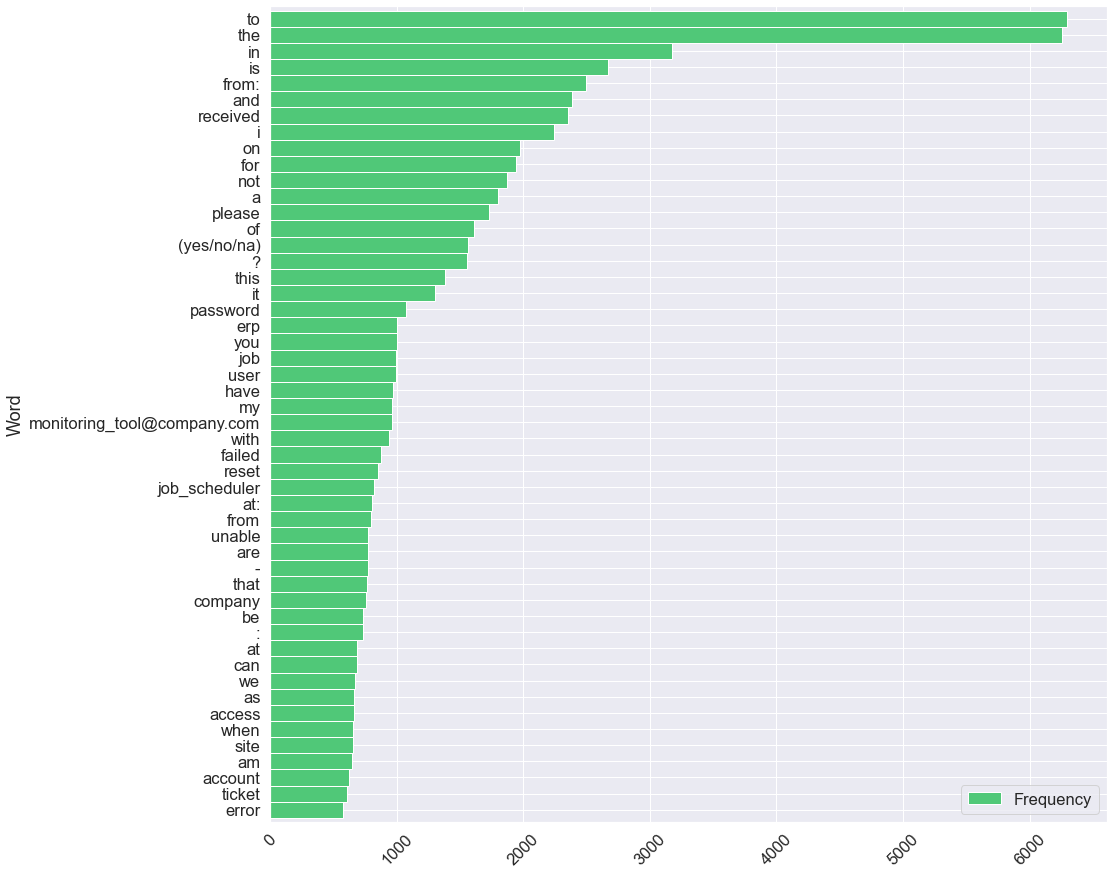

In [55]:
sns.set(font_scale=1.5)  # scale up font size
rslt.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=1, figsize=(15, 15), color=config['green_rgb'])
plt.xticks(rotation=45)
plt.show()

In [56]:
pprint(rslt.index.tolist(), compact=True)

['to', 'the', 'in', 'is', 'from:', 'and', 'received', 'i', 'on', 'for', 'not',
 'a', 'please', 'of', '(yes/no/na)', '?', 'this', 'it', 'password', 'erp',
 'you', 'job', 'user', 'have', 'my', 'monitoring_tool@company.com', 'with',
 'failed', 'reset', 'job_scheduler', 'at:', 'from', 'unable', 'are', '-',
 'that', 'company', 'be', ':', 'at', 'can', 'we', 'as', 'access', 'when',
 'site', 'am', 'account', 'ticket', 'error']


<h5><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Stopwords and Anchor words like 'From:', 'Recieved' have to be stripped out
 </span></ul></h5>

In [57]:
# top 50 most frequent words in text
top_N = config['top_n']

words = (dataset.short_description.str.cat(sep=' ').split())
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

In [58]:
rslt[:top_N].transpose()

Word         to    in  not  job   on   is  password  erp  failed  \
Frequency  2167  1737  981  976  917  856       847  822     822   

Word       job_scheduler  ...  with    i   my  crm  ticket  windows    /   am  \
Frequency            811  ...   193  191  187  185     182      177  177  168   

Word       password_management_tool  network  
Frequency                       161      155  

[1 rows x 50 columns]

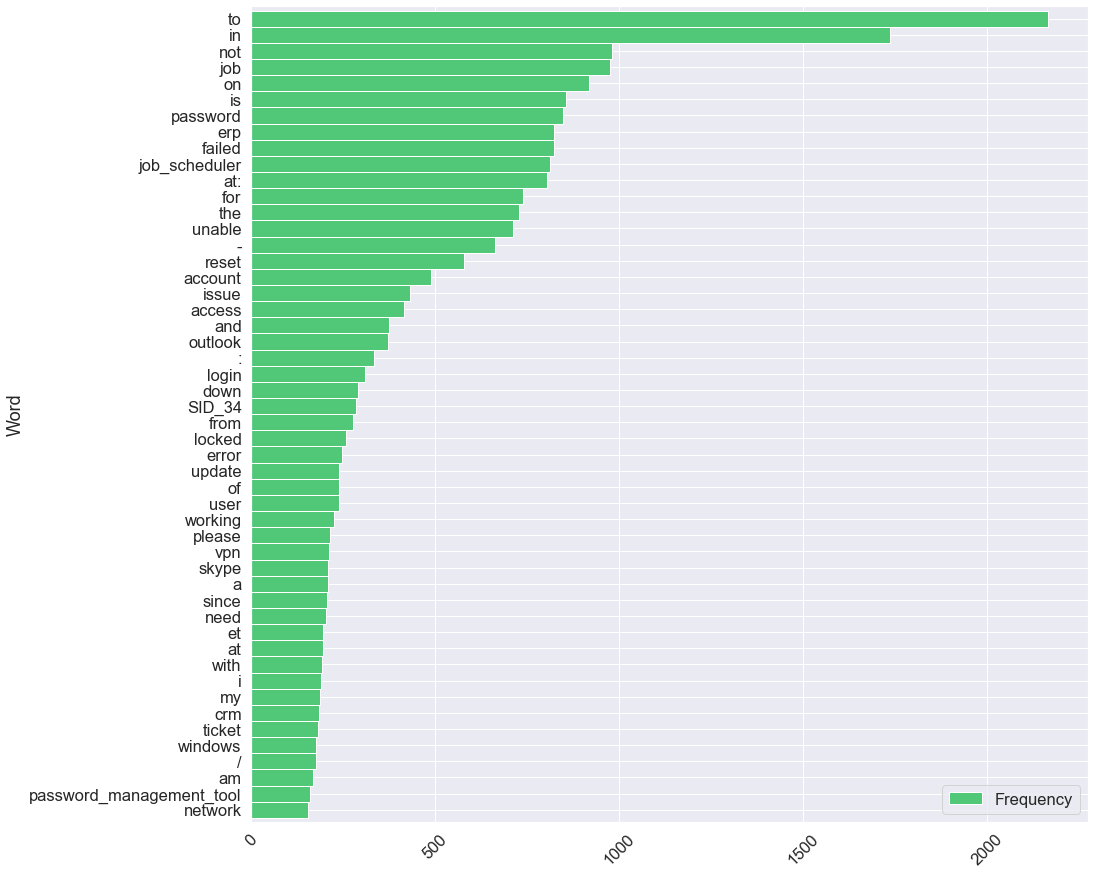

In [59]:
sns.set(font_scale=1.5)  # scale up font size
rslt.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=1, figsize=(15, 15), color=config['green_rgb'])
plt.xticks(rotation=45)
plt.show()

In [60]:
pprint(rslt.index.tolist(), compact=True)

['to', 'in', 'not', 'job', 'on', 'is', 'password', 'erp', 'failed',
 'job_scheduler', 'at:', 'for', 'the', 'unable', '-', 'reset', 'account',
 'issue', 'access', 'and', 'outlook', ':', 'login', 'down', 'SID_34', 'from',
 'locked', 'error', 'update', 'of', 'user', 'working', 'please', 'vpn', 'skype',
 'a', 'since', 'need', 'et', 'at', 'with', 'i', 'my', 'crm', 'ticket',
 'windows', '/', 'am', 'password_management_tool', 'network']


<h5><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Many stopwords are occuring most frequently in the dataset. We might need to use stopword removal in our pre-processing if it improves the model performance.
 </span></ul></h5>

In [61]:
descr_string = ""
for description in dataset['description']:
    descr_string += description
    descr_string += " "

short_descr_string = ""
for description in dataset['short_description']:
    short_descr_string += description
    short_descr_string += " "

grp0_string = ""
for description in temp.loc[temp.group == 'Group 0', 'description']:
    grp0_string += description
    grp0_string += " "

other_string = ""
for description in temp.loc[temp.group == 'Other', 'description']:
    other_string += description
    other_string += " "

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Descriptions WordCloud</span></strong></li>
</ul></h4>

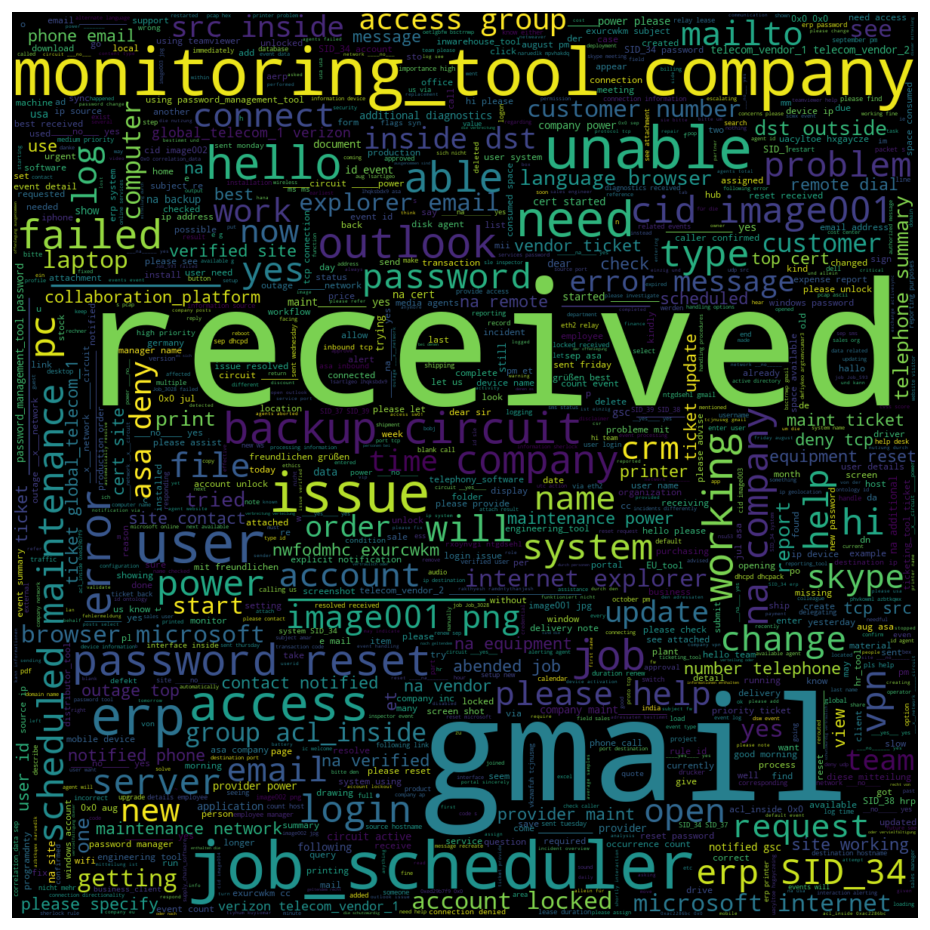

In [62]:
plt.figure(figsize=(10,10), dpi=120)
WC = WordCloud(width=1200, height=1200, max_words=1000, min_font_size=5)
plt.imshow(WC.generate(descr_string), interpolation='bilinear')
plt.axis("off")
plt.show()

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Short Descriptions WordCloud</span></strong></li>
</ul></h4>

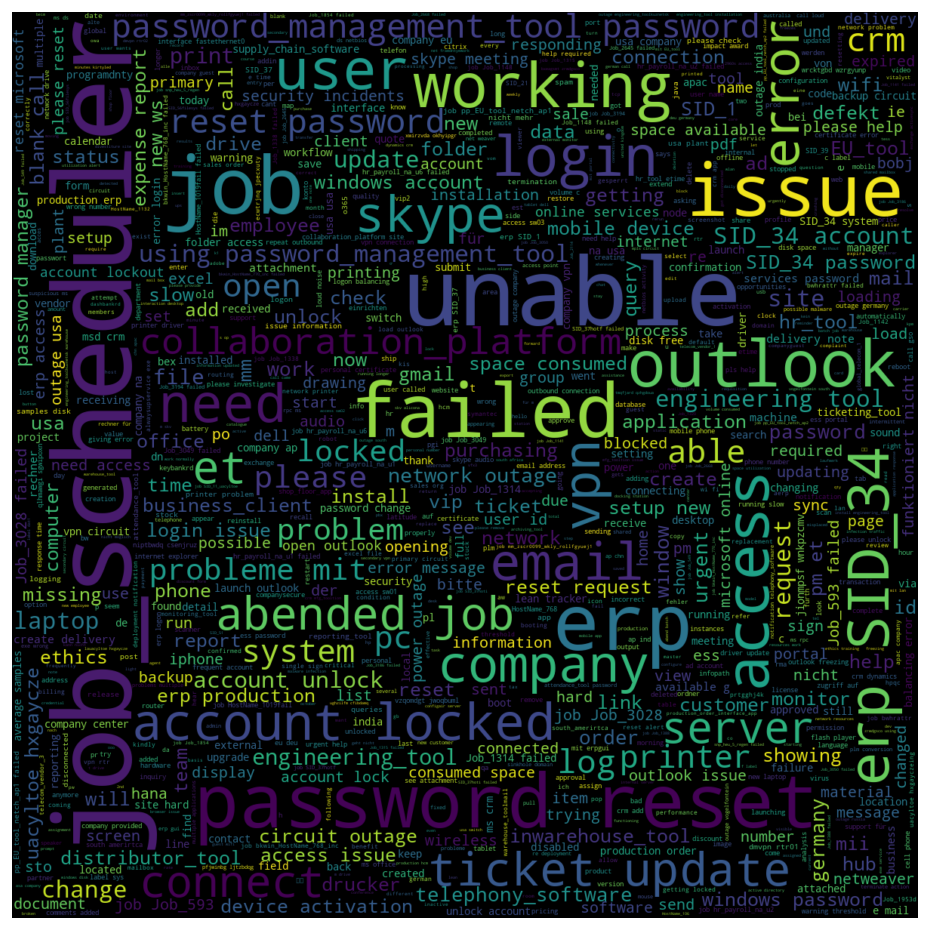

In [63]:
# Non-Sarcastic descriptions wordcloud
plt.figure(figsize=(10,10), dpi=120)
WC = WordCloud(width=1200, height=1200, max_words=1000, min_font_size=5)
plt.imshow(WC.generate(short_descr_string), interpolation='bilinear')
plt.axis("off")
plt.show()

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Group 0 Descriptions WordCloud</span></strong></li>
</ul></h4>

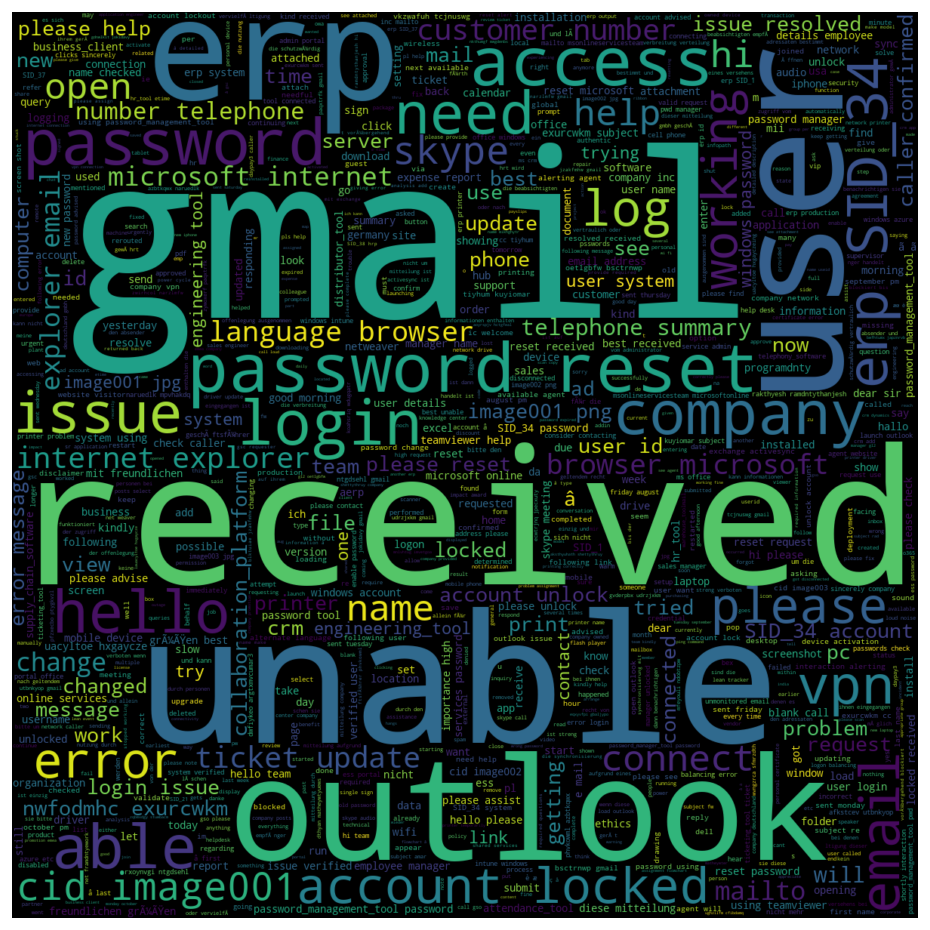

In [64]:
# Non-Sarcastic descriptions wordcloud
plt.figure(figsize=(10,10), dpi=120)
WC = WordCloud(width=1200, height=1200, max_words=1000, min_font_size=5)
plt.imshow(WC.generate(grp0_string), interpolation='bilinear')
plt.axis("off")
plt.show()

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Other Groups Descriptions WordCloud</span></strong></li>
</ul></h4>

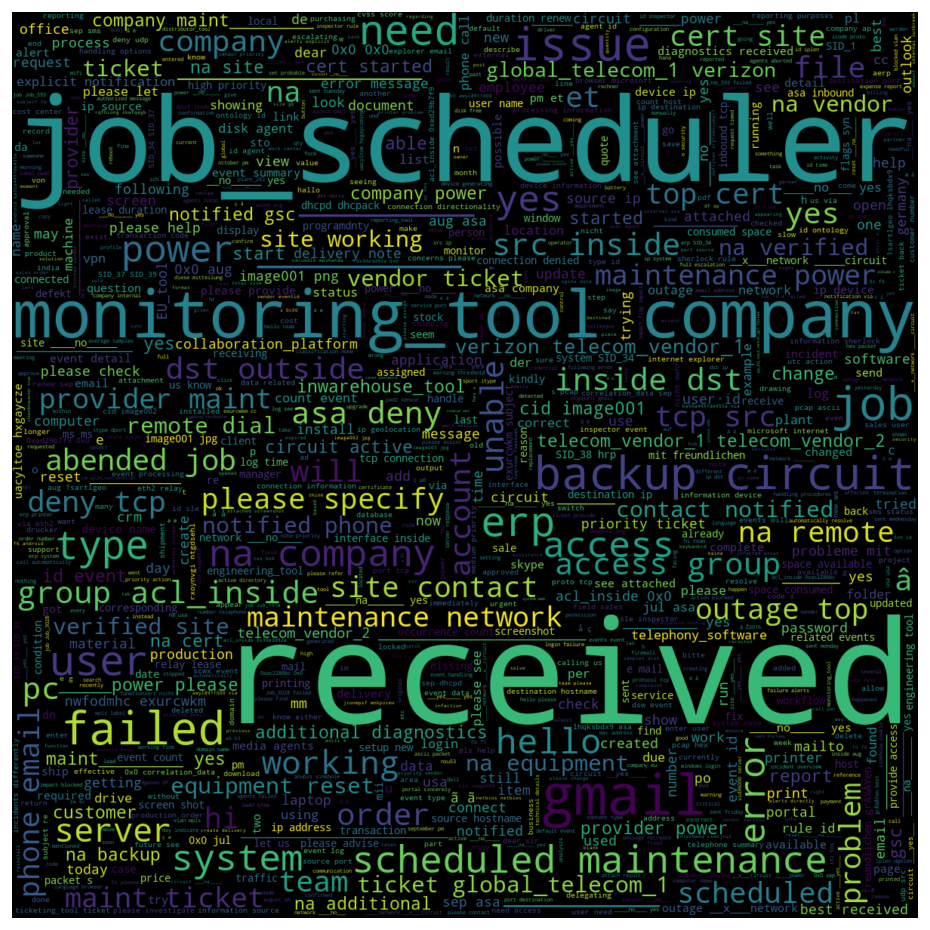

In [65]:
# Non-Sarcastic descriptions wordcloud
plt.figure(figsize=(10,10), dpi=120)
WC = WordCloud(width=1200, height=1200, max_words=1000, min_font_size=5)
plt.imshow(WC.generate(other_string), interpolation='bilinear')
plt.axis("off")
plt.show()

<h4><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Short Descriptions
 </span></ul></h4>

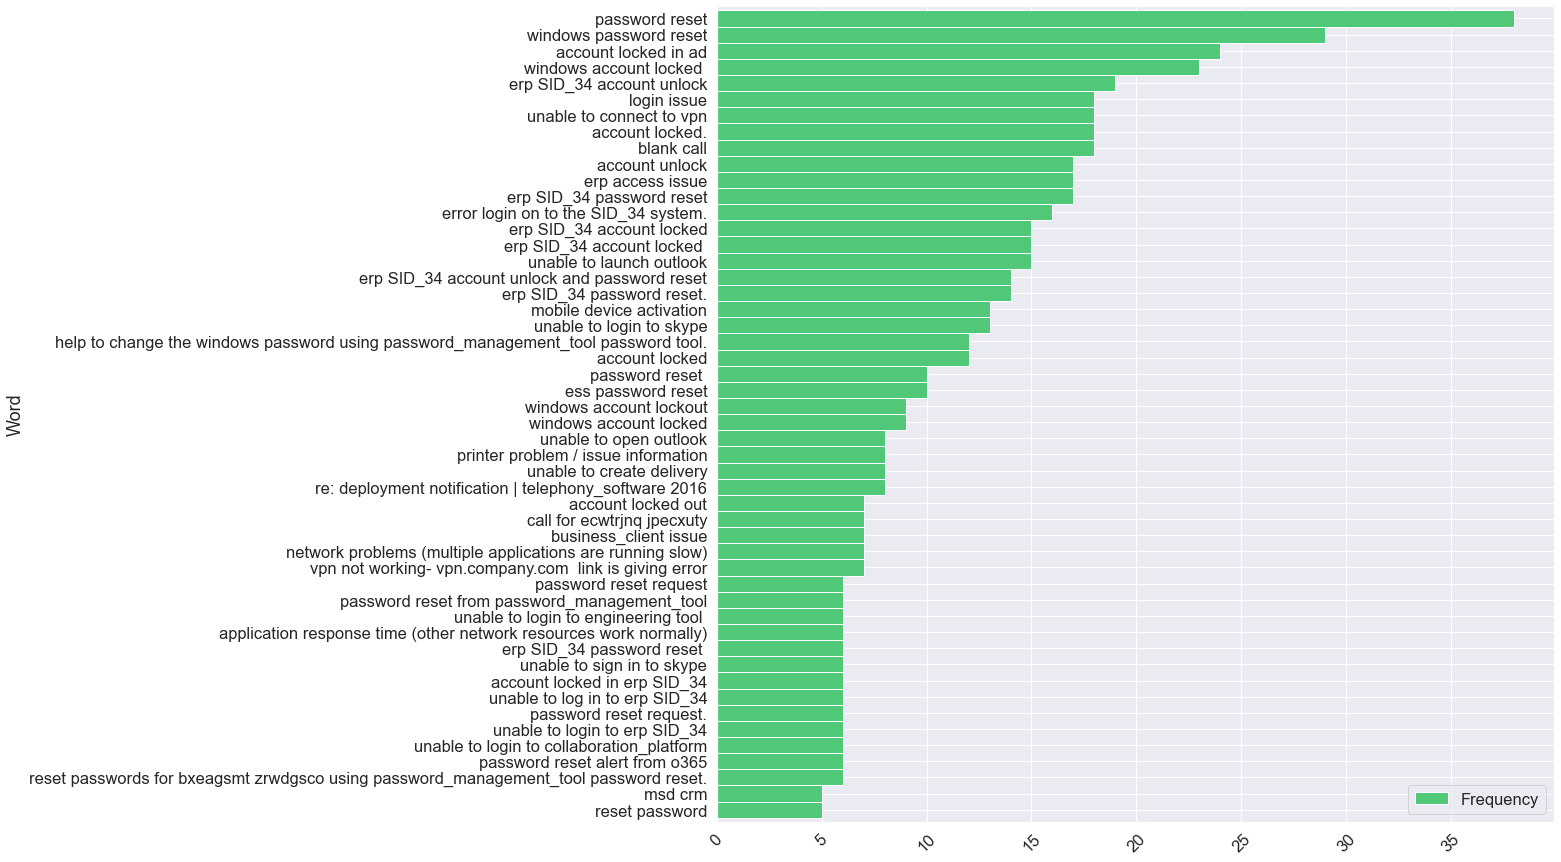

In [66]:
top_N = config['top_n']
rslt = pd.DataFrame(Counter(dataset.short_description.tolist()).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
sns.set(font_scale=1.5)  # scale up font size
rslt.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=1, figsize=(15, 15), color=config['green_rgb'])
plt.xticks(rotation=45)
plt.show()

<h4><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Descriptions
 </span></ul></h4>

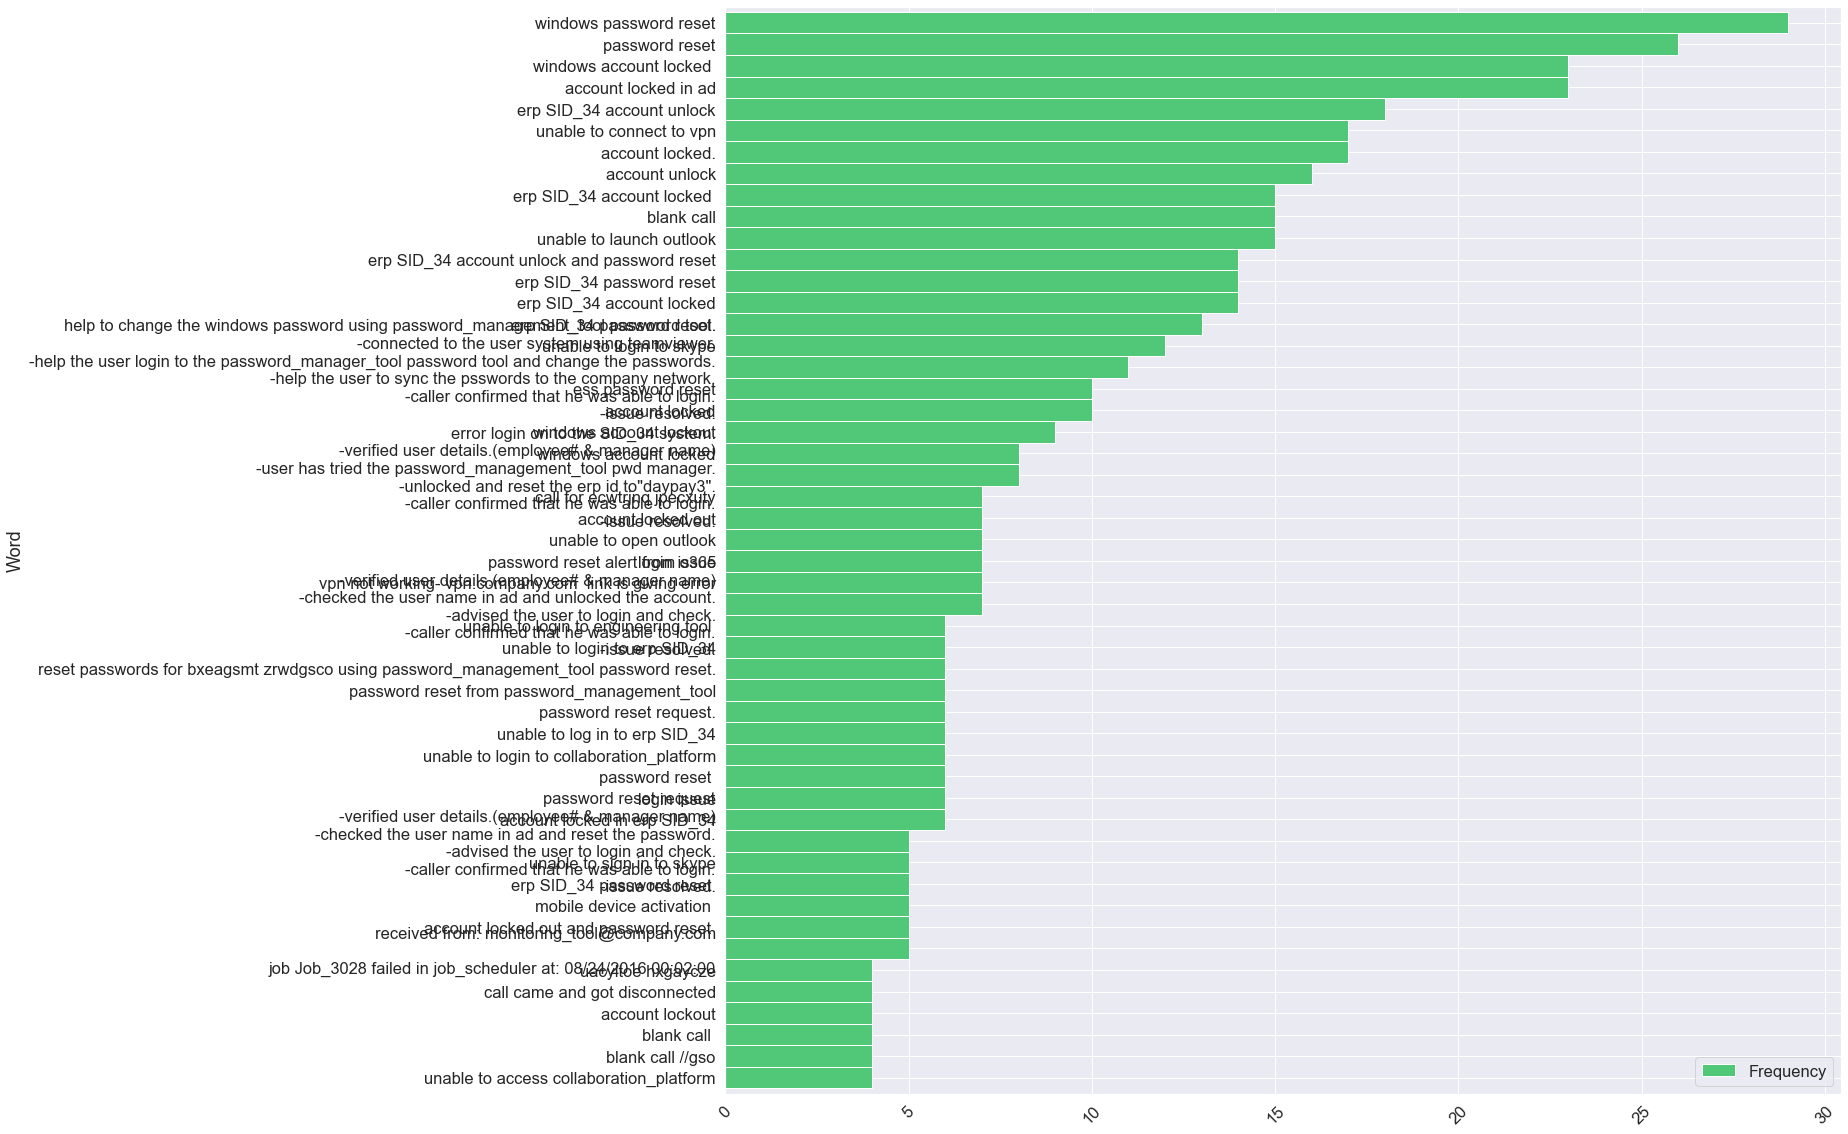

In [67]:
top_N = config['top_n']
rslt = pd.DataFrame(Counter(dataset.description.tolist()).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
sns.set(font_scale=1.5)  # scale up font size
rslt.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=1, figsize=(20, 20), color=config['green_rgb'])
plt.xticks(rotation=45)
plt.show()

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Description Lengths vs. Functional Group</span></strong></li>
</ul></h3>

In [68]:
le = LabelEncoder()
dataset['group_code'] = le.fit_transform(dataset.group)
dataset.sample(7)

short_description  \
4643  users are unable to connect to the network dri...   
6488                          zugriff auf netzlaufwerke   
7316                                            拼写和语法错误   
3893          crm portal login issue_ kxmidsga zokivdfa   
2823                                     network issues   
4027                connection to finance_app data base   
6110  job Job_551 failed in job_scheduler at: 08/28/...   

                                            description             caller  \
4643  users are unable to connect to the network dri...  bdeplqyj fewovrcq   
6488  \n\nreceived from: sthqwdpj.lpnigfyq@gmail.com...  sthqwdpj lpnigfyq   
7316                    编辑ppt时,总是弹出"无法检查拼写和语法错误",也无法安装。  jtplaoui uvsihfpn   
3893  \n\nreceived from: kxmidsga.zokivdfa@gmail.com...  kxmidsga zokivdfa   
2823  \n\nreceived from: verena.financial@company.co...  lntbvwgk doqhisxf   
4027  \n\nreceived from: naisdxtk.mqzvewsb@gmail.com...  naisdxtk mqzvewsb   
6110  received from: monitoring_tool@company.com\n\n...  bpctwhsn kzqsbmtp   

       group  char_length  word_length  short_char_length  short_word_length  \
4643  GRP_12          101           17                 66                 11   
6488   GRP_0          268           33                 25                  3   
7316  GRP_48           83            3                 21                  1   
3893  GRP_22          220           27                 41                  6   
2823  GRP_28          294           42                 14                  2   
4027  GRP_55          256           30                 35                  5   
6110   GRP_8          105           11                 61                  8   

      group_code  
4643           4  
6488           0  
7316          43  
3893          15  
2823          21  
4027          51  
6110          72

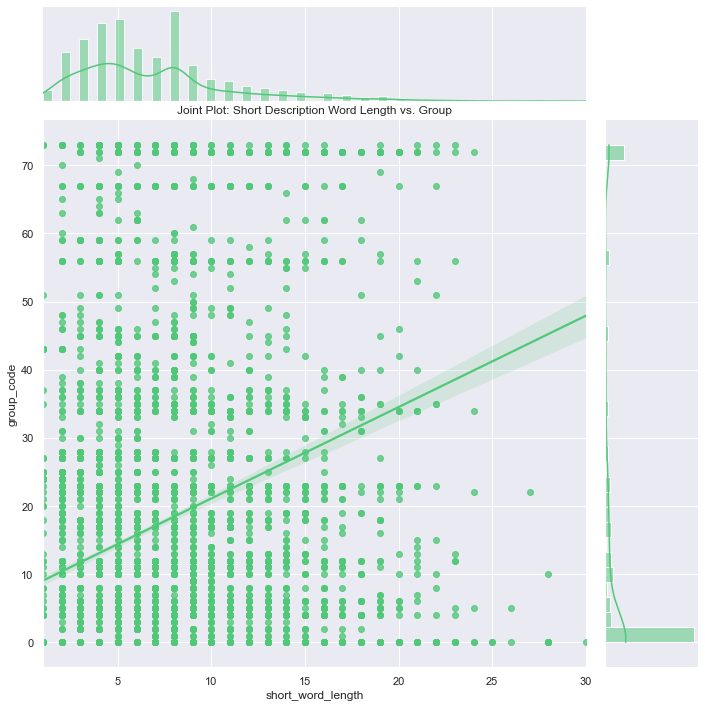

In [69]:
sns.set()
sns.jointplot(dataset.short_word_length, dataset.group_code, 
              kind='reg', color=config['green_rgb'], height=10)
plt.title('Joint Plot: Short Description Word Length vs. Group')
plt.show()

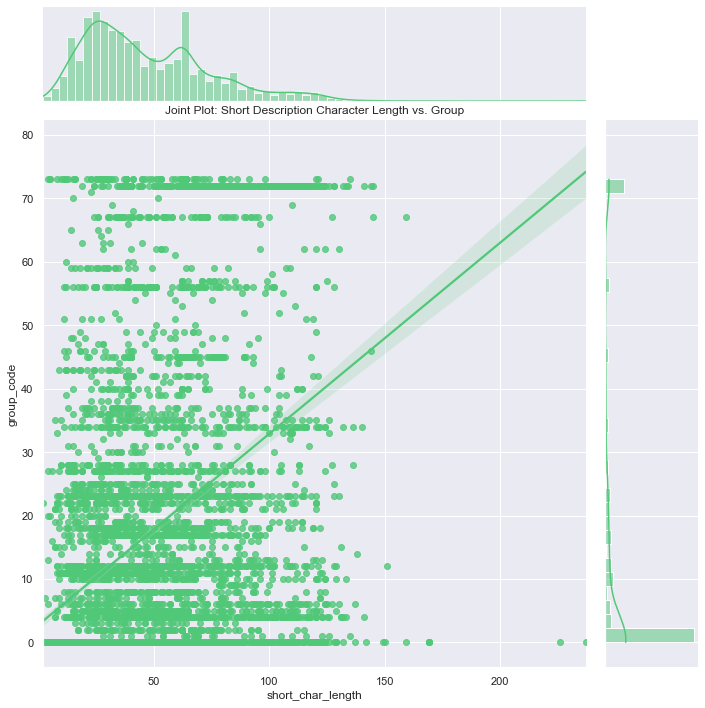

In [70]:
sns.set()
sns.jointplot(dataset.short_char_length, dataset.group_code, 
              kind='reg', color=config['green_rgb'], height=10)
plt.title('Joint Plot: Short Description Character Length vs. Group')
plt.show()

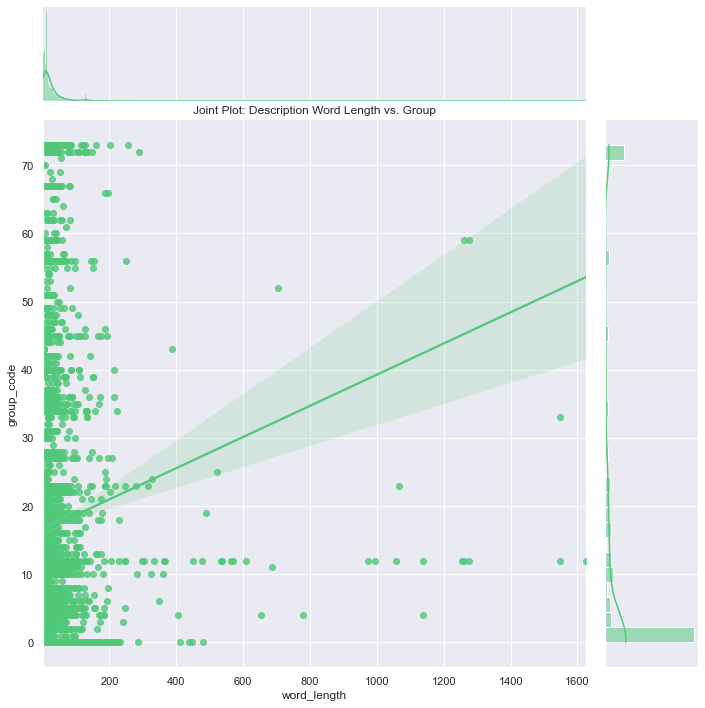

In [71]:
sns.set()
sns.jointplot(dataset.word_length, dataset.group_code, 
              kind='reg', color=config['green_rgb'], height=10)
plt.title('Joint Plot: Description Word Length vs. Group')
plt.show()

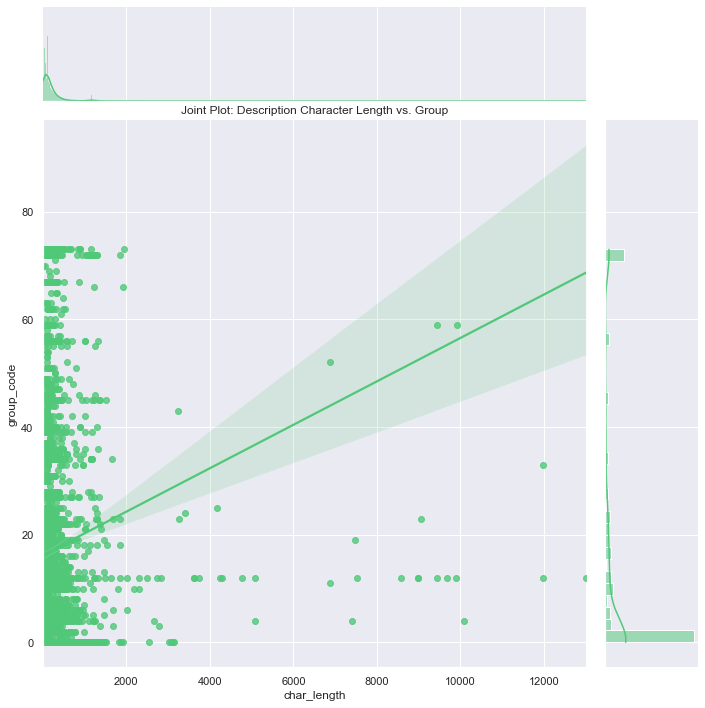

In [72]:
sns.set()
sns.jointplot(dataset.char_length, dataset.group_code, 
              kind='reg', color=config['green_rgb'], height=10)
plt.title('Joint Plot: Description Character Length vs. Group')
plt.show()

In [73]:
# binning the lengths

NUM_BINS = 100
# calculates the natural breaks in a series, exploiting the Fisher-Jenks algorithm
# https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization
breaks = jenkspy.jenks_breaks(dataset['char_length'], nb_class=NUM_BINS)
labels = list(range(len(breaks) - 1))
pprint(breaks, compact=True)

[3.0, 17.0, 23.0, 28.0, 34.0, 40.0, 47.0, 55.0, 63.0, 71.0, 80.0, 90.0, 101.0,
 109.0, 117.0, 126.0, 137.0, 149.0, 160.0, 170.0, 180.0, 190.0, 201.0, 213.0,
 224.0, 235.0, 247.0, 259.0, 271.0, 283.0, 295.0, 308.0, 323.0, 338.0, 354.0,
 372.0, 392.0, 412.0, 431.0, 449.0, 468.0, 486.0, 508.0, 537.0, 568.0, 596.0,
 620.0, 653.0, 684.0, 720.0, 765.0, 801.0, 837.0, 866.0, 908.0, 934.0, 990.0,
 1026.0, 1063.0, 1116.0, 1157.0, 1176.0, 1197.0, 1234.0, 1265.0, 1301.0, 1347.0,
 1398.0, 1478.0, 1526.0, 1692.0, 1877.0, 1952.0, 2013.0, 2172.0, 2293.0, 2548.0,
 2744.0, 2833.0, 3062.0, 3141.0, 3249.0, 3403.0, 3628.0, 3734.0, 4169.0, 4286.0,
 4766.0, 5087.0, 6887.0, 7403.0, 7524.0, 8575.0, 8991.0, 9063.0, 9440.0, 9678.0,
 9912.0, 10077.0, 11968.0, 13001.0]


In [74]:
dataset['char_length_bins'] = pd.cut(dataset['char_length'] ,bins=breaks, labels=labels, include_lowest=True)

In [75]:
dataset

short_description  \
0                                           login issue   
1                                               outlook   
2                                    cant log in to vpn   
3                         unable to access hr_tool page   
4                                          skype error    
...                                                 ...   
8495                  emails not coming in from zz mail   
8496                           telephony_software issue   
8497  vip2: windows password reset for tifpdchb pedx...   
8498                       machine não está funcionando   
8499  an mehreren pc`s lassen sich verschiedene prgr...   

                                            description             caller  \
0     -verified user details.(employee# & manager na...  spxjnwir pjlcoqds   
1     \n\nreceived from: hmjdrvpb.komuaywn@gmail.com...  hmjdrvpb komuaywn   
2     \n\nreceived from: eylqgodm.ybqkwiam@gmail.com...  eylqgodm ybqkwiam   
3                         unable to access hr_tool page  xbkucsvz gcpydteq   
4                                          skype error   owlgqjme qhcozdfx   
...                                                 ...                ...   
8495  \n\nreceived from: avglmrts.vhqmtiua@gmail.com...  avglmrts vhqmtiua   
8496                           telephony_software issue  rbozivdq gmlhrtvp   
8497  vip2: windows password reset for tifpdchb pedx...  oybwdsgx oxyhwrfz   
8498  i am unable to access the machine utilities to...  ufawcgob aowhxjky   
8499  an mehreren pc`s lassen sich verschiedene prgr...  kqvbrspl jyzoklfx   

       group  char_length  word_length  short_char_length  short_word_length  \
0      GRP_0          206           33                 11                  2   
1      GRP_0          194           25                  7                  1   
2      GRP_0           87           11                 18                  5   
3      GRP_0           29            5                 29                  5   
4      GRP_0           12            2                 12                  2   
...      ...          ...          ...                ...                ...   
8495  GRP_29          141           19                 33                  7   
8496   GRP_0           24            2                 24                  2   
8497   GRP_0           50            7                 50                  7   
8498  GRP_62          103           17                 30                  4   
8499  GRP_49           82           11                 70                  9   

      group_code char_length_bins  
0              0               22  
1              0               21  
2              0               10  
3              0                3  
4              0                0  
...          ...              ...  
8495          22               16  
8496           0                2  
8497           0                6  
8498          59               12  
8499          44               10  

[8499 rows x 10 columns]

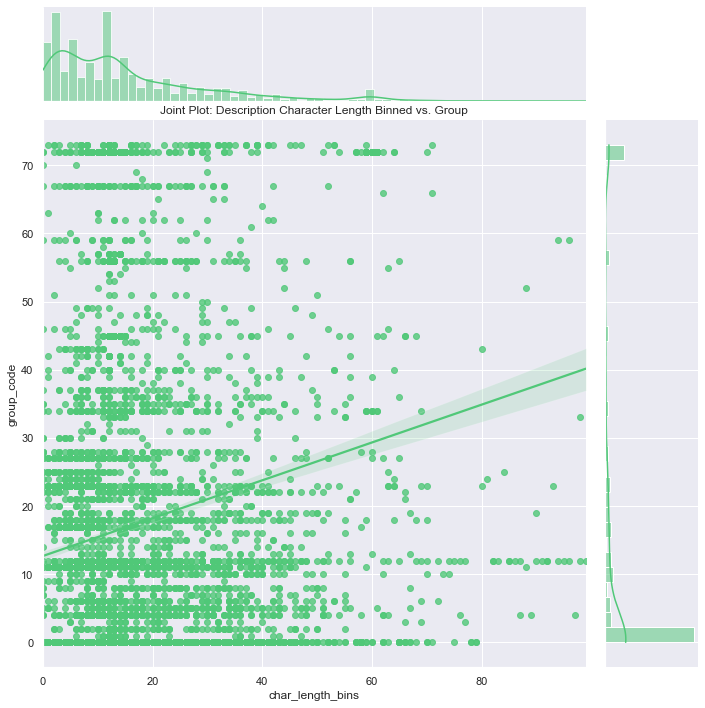

In [76]:
sns.set()
sns.jointplot(dataset.char_length_bins.astype(int), dataset.group_code, 
              kind='reg', color=config['green_rgb'], height=10)
plt.title('Joint Plot: Description Character Length Binned vs. Group')
plt.show()

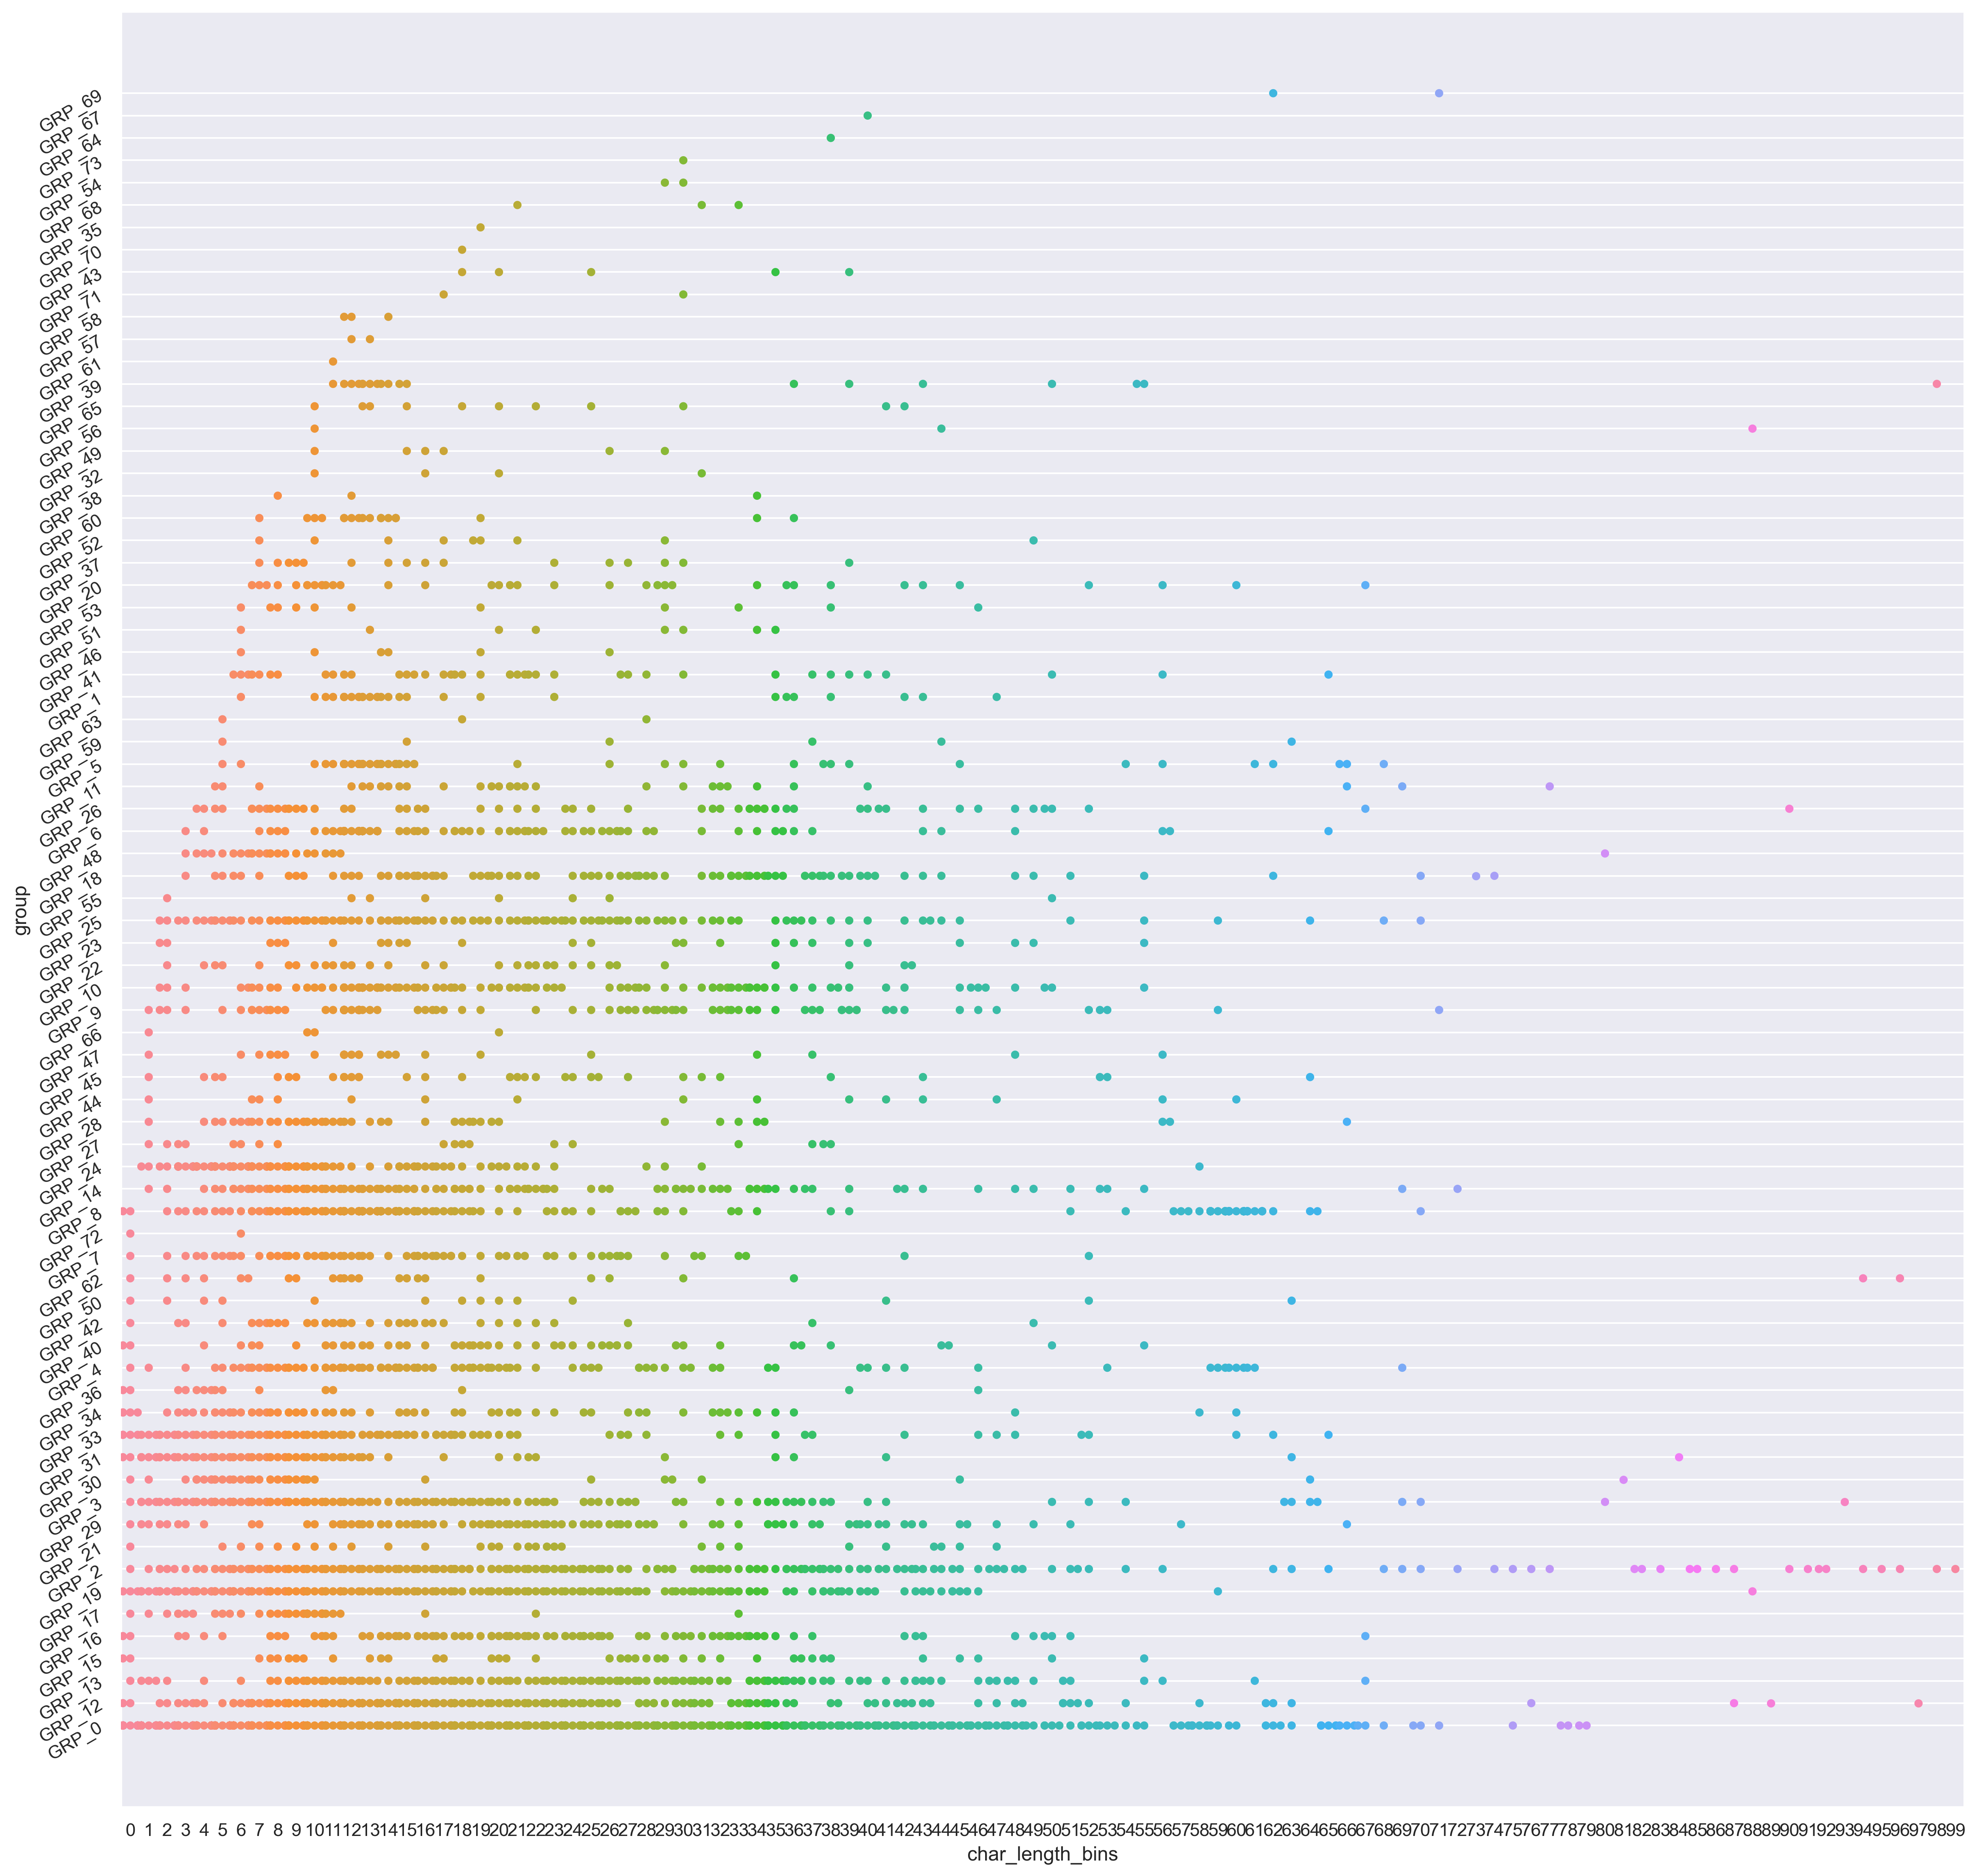

In [77]:
sns.set()
plt.figure(figsize=(20,20), dpi=300)
sns.swarmplot(x="char_length_bins", y="group", data=dataset)
plt.yticks(rotation=30)
plt.show()

In [78]:
data_crosstab = pd.crosstab(dataset['caller'],
                            dataset['group'],
                            margins=True,
                            margins_name="Total")
data_crosstab

group              GRP_0  GRP_1  GRP_10  GRP_11  GRP_12  GRP_13  GRP_14  \
caller                                                                    
DEsowkrH sciejzNE      0      0       0       0       0       1       0   
HdOuWxAt qfKdlJMx      1      0       0       0       0       0       0   
ZkBogxib QsEJzdZO      0      1       2       0       0       0       2   
abiuclvj brziktno      0      0       0       0       0       0       0   
abtknpew ifcekjdb      1      0       0       0       0       0       0   
...                  ...    ...     ...     ...     ...     ...     ...   
zylwdbig wdkbztjp      1      0       0       0       0       0       0   
zymdwqsi jzvbthil      1      0       0       0       0       0       0   
zywoxerf paqxtrfk      9      0       0       0       0       0       0   
zyxjagro vjgozhpn      2      0       0       0       0       0       0   
Total               3975     31     140      30     257     145     118   

group              GRP_15  GRP_16  GRP_17  ...  GRP_68  GRP_69  GRP_7  GRP_70  \
caller                                     ...                                  
DEsowkrH sciejzNE       0       0       0  ...       0       0      0       0   
HdOuWxAt qfKdlJMx       0       0       0  ...       0       0      0       0   
ZkBogxib QsEJzdZO       0       0       0  ...       0       0      0       0   
abiuclvj brziktno       0       0       0  ...       0       0      0       0   
abtknpew ifcekjdb       0       0       0  ...       0       0      0       0   
...                   ...     ...     ...  ...     ...     ...    ...     ...   
zylwdbig wdkbztjp       0       0       0  ...       0       0      0       0   
zymdwqsi jzvbthil       0       0       0  ...       0       0      0       0   
zywoxerf paqxtrfk       0       0       0  ...       0       0      0       0   
zyxjagro vjgozhpn       0       0       0  ...       0       0      0       0   
Total                  39      85      81  ...       3       2     68       1   

group              GRP_71  GRP_72  GRP_73  GRP_8  GRP_9  Total  
caller                                                          
DEsowkrH sciejzNE       0       0       0      0      0      2  
HdOuWxAt qfKdlJMx       0       0       0      0      0      1  
ZkBogxib QsEJzdZO       0       0       0     54     31    151  
abiuclvj brziktno       0       0       0      0      0      1  
abtknpew ifcekjdb       0       0       0      0      0      1  
...                   ...     ...     ...    ...    ...    ...  
zylwdbig wdkbztjp       0       0       0      0      0      1  
zymdwqsi jzvbthil       0       0       0      0      0      1  
zywoxerf paqxtrfk       0       0       0      0      0      9  
zyxjagro vjgozhpn       0       0       0      0      0      2  
Total                   2       2       1    661    252   8499  

[2951 rows x 75 columns]

In [79]:
# significance level
alpha = 0.05

# Calcualtion of Chisquare test statistics
chi_square = 0
rows = dataset['caller'].unique()
columns = dataset ['group'].unique()
for i in columns:
    for j in rows:
        O = data_crosstab[i][j]
        E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
        chi_square += (O-E)**2/E

# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.norm.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 268747.2241233948  and p value is: 0.0
Null Hypothesis is rejected.


<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Language Detection</span></strong></li>
</ul></h3>

In [80]:
DetectorFactory.seed = config['seed']

# detect the languages in the dataset
languages = []
errs = []
lang_samples = defaultdict(list)
for text in tqdm(dataset.description):
    try:
        lang = detect_langs(text)
        clean_lang = str(lang).split(':')[0][1:]
        lang_samples[clean_lang].append(text)
        languages.append(clean_lang)
    except LangDetectException as e:
        errs.append(text)
        print('text: ', text)
        print(e)

 74%|██████████████████████████████████████████████████████▋                   | 6284/8499 [00:40<00:13, 161.02it/s]

text:  +86  
No features in text.


100%|██████████████████████████████████████████████████████████████████████████| 8499/8499 [00:53<00:00, 158.46it/s]


In [81]:
print("Unique languages in the descriptions: "
      f"{np.unique(languages)}")

Unique languages in the descriptions: ['af' 'ca' 'cs' 'cy' 'da' 'de' 'en' 'es' 'et' 'fi' 'fr' 'hr' 'hu' 'id'
 'it' 'ja' 'ko' 'lt' 'lv' 'nl' 'no' 'pl' 'pt' 'ro' 'sk' 'sl' 'so' 'sq'
 'sv' 'sw' 'tl' 'tr' 'vi' 'zh-cn']


In [82]:
lang_freqs = {i: len(lang_samples[i]) for i in lang_samples}
freq_df = pd.DataFrame({'Language': lang_freqs.keys(), 'Frequency': lang_freqs.values()},
                      columns=['Language', 'Frequency']).set_index('Language')
freq_df.T

Language     en  no  es   it   af  sv  ca  nl   de   fr  ...  lt  ja  sk  tr  \
Frequency  7058  67  65  144  262  37  40  48  424  111  ...   4   1   1   1   

Language   sw  vi  so  lv  cs  hu  
Frequency   1   3   1   2   1   1  

[1 rows x 34 columns]

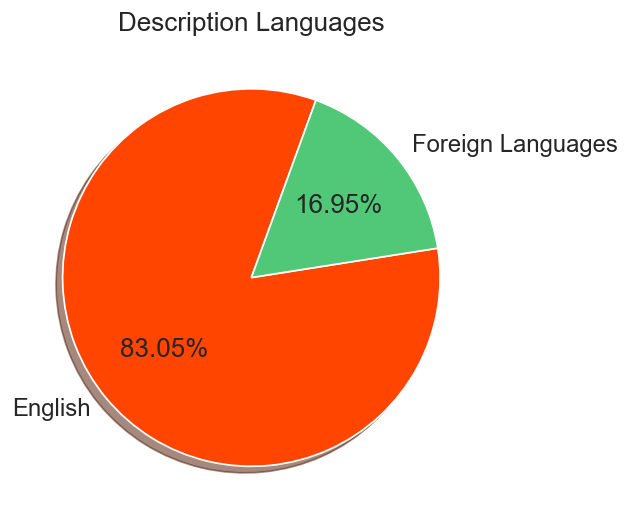

In [83]:
sns.set(font_scale=1.25)  # scale up font size

plt.figure(figsize=(5, 5), dpi=125)
eng = freq_df.loc['en'].tolist()[0]
foreign_lang = len(dataset) - freq_df.loc['en'].tolist()[0]

plt.pie(x=[eng, foreign_lang],
        explode=(0, 0),
        labels=['English', 'Foreign Languages'],
        autopct='%1.2f%%',
        shadow=True,
        startangle=70,
        colors=[config['red_rgb'], config['green_rgb']])

fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.title('Description Languages')
plt.show()

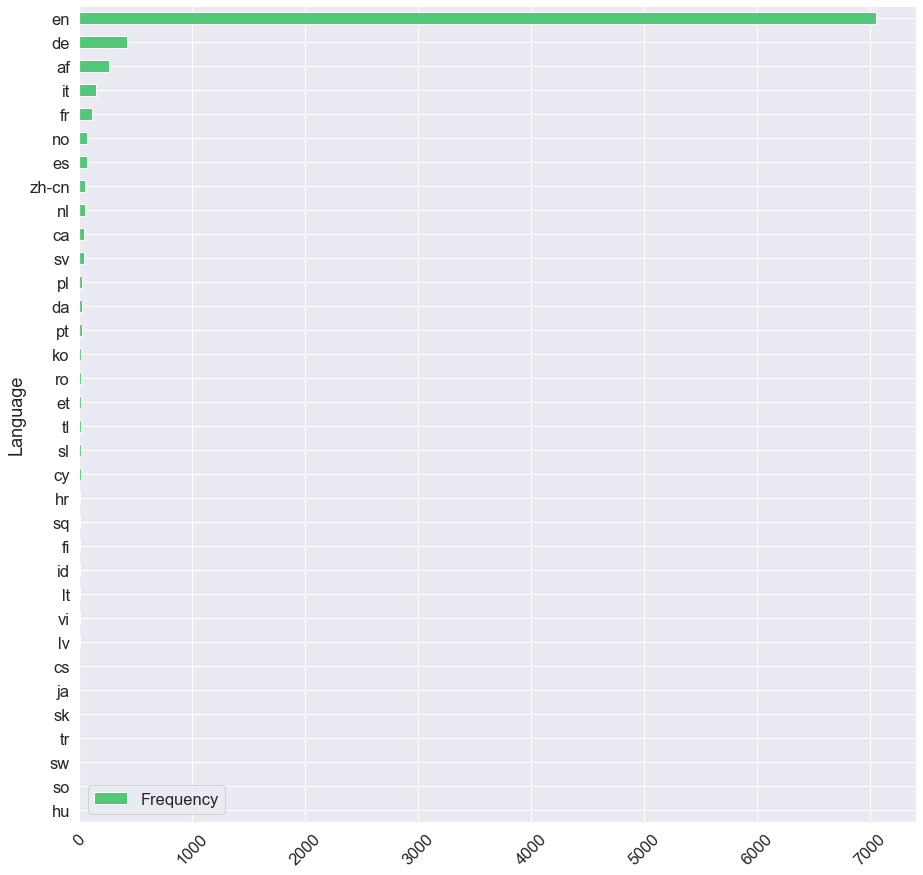

In [84]:
sns.set(font_scale=1.5)  # scale up font size
freq_df.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=0.5, figsize=(15, 15), color=config['green_rgb'])
plt.xticks(rotation=45)
plt.show()

In [85]:
# detect the languages in the dataset
languages = []
lang_samples = defaultdict(list)
for text in tqdm(dataset.short_description):
    try:
        lang = detect_langs(text)
        clean_lang = str(lang).split(':')[0][1:]
        lang_samples[clean_lang].append(text)
        languages.append(clean_lang)
    except LangDetectException as e:
        errs.append(text)
        print('text: ', text)
        print(e)

 22%|████████████████▏                                                         | 1856/8499 [00:14<00:58, 114.30it/s]

text:  bgflmyar.xgufkidq@gmail.com
No features in text.


 35%|██████████████████████████                                                | 2994/8499 [00:24<00:42, 128.58it/s]

text:  ???????????????????
No features in text.


100%|██████████████████████████████████████████████████████████████████████████| 8499/8499 [01:07<00:00, 125.00it/s]


In [86]:
print("Unique languages in the short descriptions: "
      f"{np.unique(languages)}")

Unique languages in the short descriptions: ['af' 'ca' 'cs' 'cy' 'da' 'de' 'en' 'es' 'et' 'fi' 'fr' 'hr' 'hu' 'id'
 'it' 'ko' 'lt' 'lv' 'nl' 'no' 'pl' 'pt' 'ro' 'sk' 'sl' 'so' 'sq' 'sv'
 'sw' 'tl' 'tr' 'vi' 'zh-cn']


In [87]:
lang_freqs = {i: len(lang_samples[i]) for i in lang_samples}
freq_df = pd.DataFrame({'Language': lang_freqs.keys(), 'Frequency': lang_freqs.values()},
                       columns=['Language', 'Frequency']).set_index('Language')
freq_df.T

Language     en  et   no  es   it   nl   af  sv  ro   fr  ...  vi  hr  pt  ko  \
Frequency  6121  25  157  95  287  140  489  60  45  245  ...   9   6  33  15   

Language   lt  so  sw  lv  tr  hu  
Frequency   9   5   1   4   1   1  

[1 rows x 33 columns]

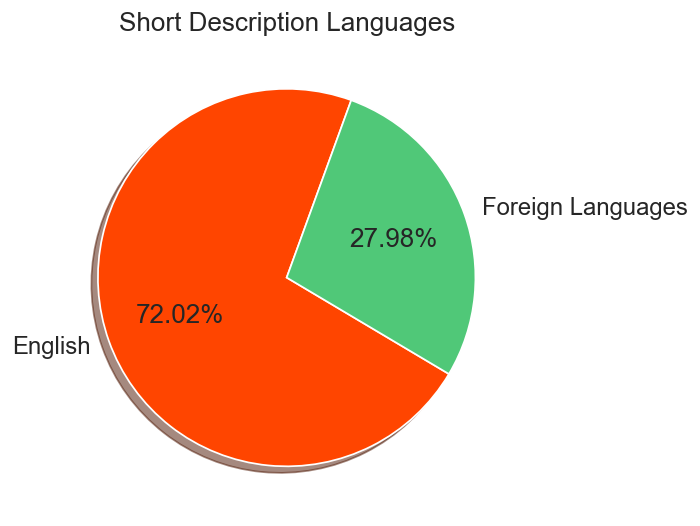

In [88]:
sns.set(font_scale=1.25)  # scale up font size

plt.figure(figsize=(5, 5), dpi=125)
eng = freq_df.loc['en'].tolist()[0]
foreign_lang = len(dataset) - freq_df.loc['en'].tolist()[0]

plt.pie(x=[eng, foreign_lang],
        explode=(0, 0),
        labels=['English', 'Foreign Languages'],
        autopct='%1.2f%%',
        shadow=True,
        startangle=70,
        colors=[config['red_rgb'], config['green_rgb']])

fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.title('Short Description Languages')
plt.show()

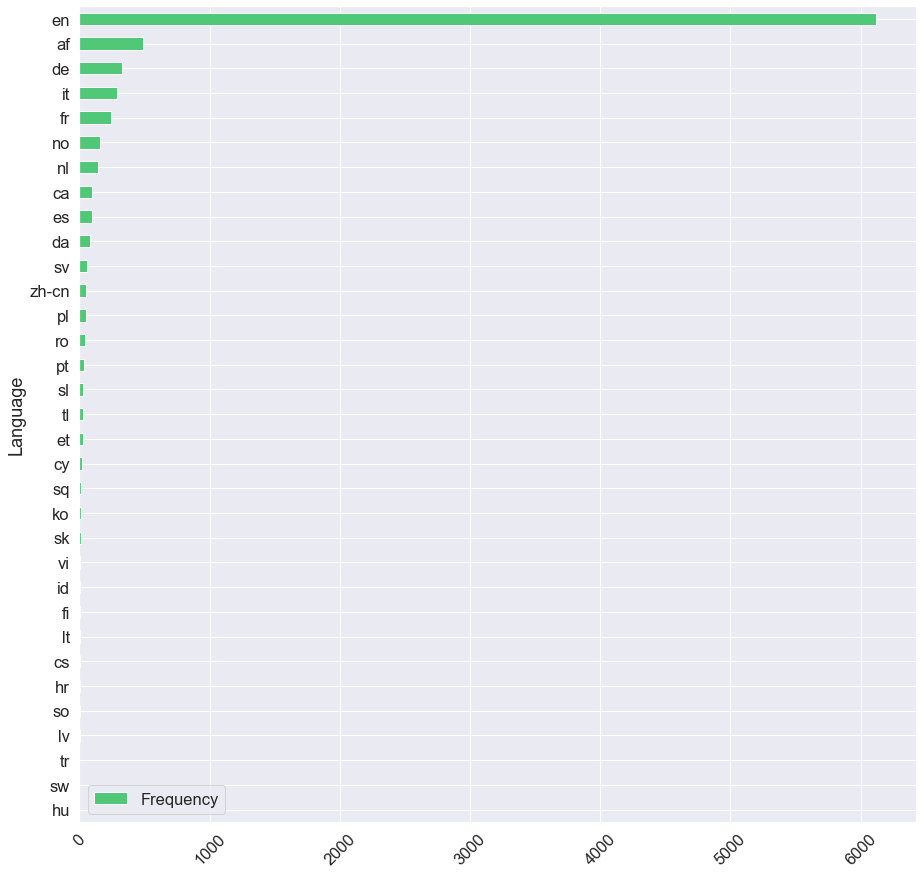

In [89]:
sns.set(font_scale=1.5)  # scale up font size
freq_df.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=0.5, figsize=(15, 15), color=config['green_rgb'])
plt.xticks(rotation=45)
plt.show()

In [90]:
errs  # few errors where lang_detect failed, need to impute these irrelevant values

['+86  ', 'bgflmyar.xgufkidq@gmail.com', '???????????????????']

In [91]:
dataset[dataset.description == errs[0]]

short_description description  \
6253  in the inbox always show there are several ema...       +86     

                 caller  group  char_length  word_length  short_char_length  \
6253  mqbxwpfn uclrqfxa  GRP_0            5            1                 94   

      short_word_length  group_code char_length_bins  
6253                 19           0                0

In [92]:
dataset.loc[dataset.description == errs[0], 'description'] = dataset[dataset.description == errs[0]].short_description

In [93]:
dataset[dataset.short_description == errs[1]]

short_description  \
1836  bgflmyar.xgufkidq@gmail.com   

                                            description             caller  \
1836  bgflmyar.xgufkidq@gmail.com wanted to check if...  olckhmvx pcqobjnd   

      group  char_length  word_length  short_char_length  short_word_length  \
1836  GRP_0           83           13                 27                  1   

      group_code char_length_bins  
1836           0               10

In [94]:
dataset.loc[dataset.short_description == errs[1], 'short_description'] = dataset[dataset.short_description == errs[1]].description

In [95]:
dataset[dataset.short_description == errs[2]]

short_description                                        description  \
2975  ???????????????????  \n\nreceived from: yzbjhmpw.vzrulkog@gmail.com...   

                 caller  group  char_length  word_length  short_char_length  \
2975  yzbjhmpw vzrulkog  GRP_0         1207          131                 19   

      short_word_length  group_code char_length_bins  
2975                  1           0               62

In [96]:
dataset.loc[dataset.short_description == errs[2], 'short_description'] = dataset[dataset.short_description == errs[2]].description

In [97]:
def clean_incosistencies():
    dataset.loc[dataset.description == errs[0], 'description'] = dataset[dataset.description == errs[0]].short_description
    dataset.loc[dataset.short_description == errs[1], 'short_description'] = dataset[dataset.short_description == errs[1]].description
    dataset.loc[dataset.short_description == errs[2], 'short_description'] = dataset[dataset.short_description == errs[2]].description

# clean_incosistencies()

<h2><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Pre-Processing</span></strong></li>
</ul></h2>

In [98]:
dataset.sample(10)

short_description  \
995   bei herrn potthryzler (benutzerkennung: potsff...   
4710  help reset erp SID_37 bw production account pa...   
3247  getting error while accessing it support revie...   
3130                             sound system of laptop   
6025  job bkwin_HostName_768_inc failed in job_sched...   
4684                               passwörter wothyehre   
6632    access requited for vl02n for post goods issues   
4816  please install project 2013 back on the client...   
5804  all permissions for discounts has been removed...   
8264  can't login to skype ,indicate certificate exp...   

                                            description             caller  \
995   fehlermeldung: systemfehler &h91115116 \n\nwit...  txkgmwbc qohmgwrp   
4710  erp SID_37 bw production account password  cha...  smktofel etsoirbw   
3247                               pl refer attachment   ginjmaxk zumkvfeb   
3130  \n\nreceived from: ygkzwsud.cvjgkxws@gmail.com...  ygkzwsud cvjgkxws   
6025  received from: monitoring_tool@company.com\n\n...  bpctwhsn kzqsbmtp   
4684  \n\nreceived from: dgwrmsja.jzlpwuit@gmail.com...  dgwrmsja jzlpwuit   
6632  \n\nreceived from: wrelsfqa.qfwosjkh@gmail.com...  wrelsfqa qfwosjkh   
4816  please install project 2013 back on the client...  asxmeruj drqufvgj   
5804  all permissions for discounts has been removed...  uajiymhe qyrwfkvz   
8264         skype for business software can't be used   mqbxwpfn uclrqfxa   

       group  char_length  word_length  short_char_length  short_word_length  \
995   GRP_33          184           23                 96                 11   
4710   GRP_0          311           35                 64                  9   
3247  GRP_19           20            3                 82                 13   
3130  GRP_19          249           36                 22                  4   
6025   GRP_5          120           11                 76                  8   
4684   GRP_0          173           18                 21                  2   
6632   GRP_2          245           35                 47                  8   
4816   GRP_3           50            9                 50                  9   
5804   GRP_0          110           19                110                 19   
8264   GRP_0           42            7                 51                  7   

      group_code char_length_bins  
995           27               20  
4710           0               31  
3247          11                1  
3130          11               26  
6025          45               14  
4684           0               19  
6632          12               25  
4816          23                6  
5804           0               13  
8264           0                5

### Pipeline
* fix text encoding usng ftfy.fix_text
* clean up outage questionnaires
* clean up security logs
* parse email messages to retain only subject and body
* clean up emails, links, website links, telephone numbers
* clean up anchor words like: 'Received from:', 'name:', 'hello', 'hello team' , 'cid' ...
* clean html tags if they exist
* clean /r /n characters
* strip caller names in descriptions
* translate accented characters (á -> a)
* convert unicode characters to ascii
* expand contractions (they're -> they are)
* clean stopwords & any custom stopwords
* clean up extra whitespaces & tokenize
* remove gibberish (after language translation)
* strip extra punctuation
* lemmatization
* handle other languages (translated after basic pre-processing is applied on english text)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Outage Questionnaires</span></strong></li>
</ul></h3>

In [99]:
outage_df = dataset.reset_index().loc[pd.Series(['outage' in i for i in  dataset.description.tolist()])]

In [100]:
outage_df.group.value_counts()

GRP_8     139
GRP_4      16
GRP_0       8
GRP_16      1
Name: group, dtype: int64

In [101]:
outage_df

index                                  short_description  \
78       78  power outage:UK al, 1st and 5th ave sites hard...   
79       79  power outage : germany, mx: site is hard down ...   
189     189  network outage: india: site hard down since at...   
215     215  network outage  - warehouse: node company-ups-...   
240     240  power outage :australia australia: site hard d...   
...     ...                                                ...   
8097   8098  network outage, russia ru, company-russia-vpn-...   
8184   8185  circuit outage: vogelfontein, south africa mpl...   
8272   8273  network outage : south amerirtca(argentina) si...   
8274   8275  network outage: usa site is hard down since 05...   
8315   8316  network outage: sao pollaurido-mercedes benz p...   

                                            description             caller  \
78    what type of outage:  _____network     _____ci...  mnlazfsr mtqrkhnx   
79    what type of outage:  ___x__network     _____c...  jyoqwxhz clhxsoqy   
189   what type of outage:  __x___network     _____c...  mnlazfsr mtqrkhnx   
215   what type of outage:  __x___network     _____c...  jyoqwxhz clhxsoqy   
240   what type of outage:  __x___network     _____c...  utyeofsk rdyzpwhi   
...                                                 ...                ...   
8097  what type of outage:  _x____network     _____c...  uxgrdjfc kqxdjeov   
8184  what type of outage:  _____network     ___x__c...  jyoqwxhz clhxsoqy   
8272  what type of outage:  ____x_network     _____c...  vbwszcqn nlbqsuyv   
8274  what type of outage:  _x____network     _____c...  vbwszcqn nlbqsuyv   
8315  what type of outage:  __x___network     _____c...  dkmcfreg anwmfvlg   

      group  char_length  word_length  short_char_length  short_word_length  \
78    GRP_8         1197          132                 82                 17   
79    GRP_8         1156          129                 74                 14   
189   GRP_8         1163          130                 86                 16   
215   GRP_8         1152          128                 80                 11   
240   GRP_8         1167          132                 78                 13   
...     ...          ...          ...                ...                ...   
8097  GRP_8         1172          130                123                 16   
8184  GRP_8         1158          130                 86                 15   
8272  GRP_8         1148          129                 88                 14   
8274  GRP_8         1152          130                 65                 13   
8315  GRP_8         1188          130                113                 17   

      group_code char_length_bins  
78            72               61  
79            72               59  
189           72               60  
215           72               59  
240           72               60  
...          ...              ...  
8097          72               60  
8184          72               60  
8272          72               59  
8274          72               59  
8315          72               61  

[164 rows x 11 columns]

In [102]:
outage_df.group.value_counts()

GRP_8     139
GRP_4      16
GRP_0       8
GRP_16      1
Name: group, dtype: int64

In [103]:
print(outage_df.description.tolist()[0])

what type of outage:  _____network     _____circuit     ___x__power (please specify what type of outage)

1. top 23 cert site   ?    ___yes______     (yes/no/na) 

2. when did it start  ?   ________4:31 pm et on 10/30. _____________

3.  scheduled maintenance ( power) ? __yno_____    (yes/no/na)     company power  _________     provider power _________
                
4.  scheduled maintenance ( network) ? ___no____    (yes/no/na)     company maint________ (yes/no)       provider maint/ticket #__________________    

5. does site have a backup circuit ?  __yes____    (yes/no/na) 

6. backup circuit active ?   ___na_____     (yes/no/na) 

7. site contact notified (phone/email) ?  _________     (yes/no/na) 

8. remote dial-in ?   ____na_______   (yes/no/na) 

9. equipment reset ?    ____na_______    (yes/no/na) 

10. verified site working on backup circuit ?  ___na____     (yes/no/na) 

11. vendor ticket  # ( global_telecom_1, verizon, telecom_vendor_1, telecom_vendor_2 )    ____global_

In [105]:
def clean_outageq(text: str) -> str:
    """cleans up outage questionaires"""
    if text.startswith('what type of outage'):
        text = ' '.join(text.splitlines())
        text=text.replace("phone",'')
        text=text.replace('email','')
        text=re.sub(r'\n+|\s\s+','',text)
        text=re.sub(r'(\_x000D\_)+','br',text)
        text=re.sub(r'(\(yes\/no\/na\))+|(\(yes\/no\))','br',text)
        temp=text.split('br')
        new=[]
        for x in temp:
            x=str(x)
            x=re.sub(r'\d\:\d+','',x)
            if 'yes'in x:
                x=re.sub(r'\?|(\_)+|\d\.','',x)
                x=re.sub('yes','',x)
            elif 'no' in x:
                x=re.sub(r'\?|(\_)+|\d\.','',x)
                x=re.sub('no','',x)
                x='no'+' '+x
            else:
                x=re.sub(r'\?|(\_)+|\d\.','',x)
                
            new.append(''.join(x))
        text=''.join(new)
        text = re.sub(r'[.,_"\'#-?:!;]', '', str(text))
        text=text.replace('yesnona','')
        text=text.replace('yesno','')
        text= " ".join(text.split())
        text=re.sub(r'what\stype\sof\soutage\:networkcircuitxpower\s\(please\sspecify\swhat\stype\sof\soutage\)','',text)
    return str(text.strip())

In [106]:
print(clean_outageq(outage_df.description.tolist()[0]))

what type of outagenetworkcircuitxpower please specify what type of outage top cert siteno when did it start pm et on scheduled maintenance power yno company powerprovider power scheduled maintenance network company maint provider maintticket does site have a backup circuit backup circuit active nano site contact tified remote dialin na equipment reset na verified site working on backup circuit nano vendor ticket globaltelecom verizon telecomvendor telecomvendor globaltelecom tifiedgsccert startedno additional diagstics


<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Security/Event Logs</span></strong></li>
</ul></h3>

In [107]:
dataset.reset_index().loc[pd.Series(['source ip' in i for i in  dataset.description.tolist()])]  # all security incident logs

index                                  short_description  \
341     341  security incidents - ( #in33071122 ) :[ipbl]: ...   
2977   2978  security incidents - ( #in33987594) : 29866 vi...   
3096   3097  security incidents - ( #in33976733) : suspicio...   
3097   3098  security incidents - ( #in33984033) : internal...   
3529   3530  security incidents - ( #in33944691 ) : possibl...   
3531   3532  security incidents - ( #in33944327) :possible ...   
3704   3705  security incidents - ( #in33932723 ) : possibl...   
3705   3706  security incidents - ( #in33924718 ) : possibl...   
3960   3961  security incidents - ( #in33805815) : possible...   
3964   3965  security incidents - ( #in33809307 ) : possibl...   
4086   4087  security incidents - ( sw #in33895560 ) : mage...   
4088   4089  security incidents - ( sw #in33895560 ) : mage...   
4729   4730  security incidents - (  #in33847938) : possibl...   
4824   4825   incident #in33541962 - phishing form submit -...   
4885   4886  security incidents - ( #in33826812 ) : possibl...   
4892   4893  security incidents - ( #in33826812 ) : possibl...   
5091   5092  security incidents - ( #in33578632) : suspicio...   
5432   5433  security incidents - ( #in33765965 ) : possibl...   
5503   5504   incident #in33541962 - phishing form submit -...   
5505   5506                                     dsw in22457494   
5506   5507  possible vulnerability scan from host.my-tss.c...   
6063   6064  engineering_tool installation issue for distri...   
6733   6734  security incidents - ( dsw incident no ) : sus...   
6749   6750  security incidents - ( #in33669678 ) : possibl...   
6887   6888  security incidents - (#in33655554) : errata se...   
6930   6931  '51551 vid67965 microsoft windows httpsys rce ...   
6936   6937   [hw] filesystem near capacity - h:(HostName_894)   
7080   7081           possible bash command injection attempt    
7150   7151  security incidents - ( in33426117 ) : correlat...   
7153   7154  security incidents - ( #in33417637 ) : repeat ...   
7330   7331  security incidents - ( #in33505432 ) : repeat ...   
7337   7338  security incidents - ( #in33505432 ) : repeat ...   
7344   7345  security incidents - ( sw #in33501789 ) : broa...   
7347   7348                HostName_480 - verify filesystem h:   
7351   7352      event summary: [hw] service icmp/icmp is down   
7353   7354      event summary: [hw] service icmp/icmp is down   
7354   7355      event summary: [hw] service icmp/icmp is down   
7355   7356                    HostName_68 near capacity - 90%   
7646   7647  security incidents - ( #in33578632) : suspicio...   
7981   7982  security incidents - ( dsw #in33390850 ) : sus...   
7983   7984  security incidents - ( dsw #in33390850 ) : sus...   
7986   7987  security incidents - (in33536629) : possible t...   
7988   7989  security incidents - ( dsw #in33407676 ) : tra...   
7990   7991  as per inc1530161::security incidents - ( in33...   
7994   7995  security incidents - ( dsw #in33407676 ) : tra...   
7995   7996  security incidents - ( in33490582 ) : suspicio...   
7996   7997  security incidents - ( sw #in33544563 ) : poss...   
8001   8002  security incidents - ( sw #in33544563 ) : poss...   

                                            description             caller  \
341   source ip :\nsystem name :lmsl9516338\nuser  n...  gzhapcld fdigznbk   
2977  source ip :\nsystem name :\nuser  name:\nlocat...  gzhapcld fdigznbk   
3096  source ip: 10.16.90.249\nsource hostname: andr...  gzhapcld fdigznbk   
3097  source ip :\nsystem name :\nuser  name:\nlocat...  gzhapcld fdigznbk   
3529  source ip: 195.272.28.222\nsource port: 80\nso...  gzhapcld fdigznbk   
3531  source ip :\nsystem name :\nuser  name:\nlocat...  gzhapcld fdigznbk   
3704  source ip: 10.44.63.52\nsource hostname: leeng...  gzhapcld fdigznbk   
3705  source ip :195.22.28.222\ndestination ip: 12.9...  gzhapcld fdigznbk   
3960  =========================\nevent data\n=======...  gzhapcld fdi

In [108]:
dataset.reset_index().loc[pd.Series(['source ip' in i for i in  dataset.description.tolist()])].group.value_counts()  # groups

GRP_2     26
GRP_39     4
GRP_12     4
GRP_3      4
GRP_62     2
GRP_30     1
GRP_19     1
GRP_0      1
GRP_69     1
GRP_56     1
GRP_48     1
GRP_47     1
GRP_31     1
Name: group, dtype: int64

In [109]:
dataset.reset_index().loc[pd.Series(['cyber' in i for i in  dataset.short_description.tolist()])]

index                                  short_description  \
491     491          october cyber security month - ransomware   
1729   1729  cyber security - phish uacyltoe hxgaycze repor...   
5411   5412  cyber security - phish uacyltoe hxgaycze repor...   

                                            description             caller  \
491           october cyber security month - ransomware  pyrtfdxu nxfkqmoy   
1729  cyber security - phish uacyltoe hxgaycze repor...  ugyothfz ugrmkdhx   
5411  cyber security - phish uacyltoe hxgaycze repor...  ugyothfz ugrmkdhx   

      group  char_length  word_length  short_char_length  short_word_length  \
491   GRP_0           42            6                 42                  6   
1729  GRP_2           60            9                 60                  9   
5411  GRP_2           62            9                 62                  9   

      group_code char_length_bins  
491            0                5  
1729          12                7  
5411          12                7

In [110]:
def remove_duplicates(text: str) -> str:
    """Remove duplicates"""
    text = text.split(" ")
    for i in range(0, len(text)):
        text[i] = "".join(text[i])
    UniqW = Counter(text)
    text = " ".join(UniqW.keys())
    return str(text)

# remove_duplicates(text)

In [111]:
log = dataset.reset_index().loc[pd.Series(['source ip' in i for i in  dataset.description.tolist()])].iloc[1].description
print(log)

source ip :
system name :
user  name:
location :
sep , sms status :
field sales user ( yes / no) :  
dsw event log:
-------------------------------------------------------------------------------------------------------------------
event detail(s):

event_id 417013204:
[**] [1:21130977:10] 29866 vid22518 bare http get executable from ip address (possible downloader trojan) [**]
[classification: none] [priority: 2] [action: accept_passive] [impact_flag: 0] [impact: 0] [blocked: 2] [vlan: 0] [mpls label: 0] [pad2: 1]
[sensor id: 602982][event id: 281895][time: 2585087487.272206]
[xref => vid, 22518]
[src ip: 10.1.43.79][dst ip: 94.102.53.238][sport/itype: 61007][dport/icode: 80][proto: 6]
09/27/2016-11:39:36.272206 10.1.43.79:61007 -> 94.102.53.238:80
tcp ttl:127 tos:0x0 id:16297 iplen:20 dgmlen:119 df
***ap*** seq: 0xfbc9dc8c ack: 0xe57c9433 win: 0x102 tcplen: 20
==pcap s==
=0c=00=00=00xz=eawn'=04=00w=00=00=00w=00=00=00e=00=00w?=a9@=00=7f=06=f23=0a=01+o^f5=ee=eeo=00p=fb=c9=dc=8c=e5|=943

In [112]:
def clean_sec_logs(text: str) -> str:
    """Clean up security logs"""
    if text.startswith('source ip'):
        words = set(['source','ip','hostname', 'mac', 'events', 'yes / no'])
        word_cleanup = r'\b(?:{})\b'.format('|'.join(words))
        text = text.replace('\n', ' ').replace('\r', '')
        text = re.sub(r'((:)?\s?\d+(.|:)?)+', '', text)
        text = re.sub('(_x000D_|_x_|_x|x_)', '', text)
        text = re.sub(r'(\[|\]|(\-)+|(\=)+|\%|\,|\"|\:|\(|\))?','', text)
        text = re.sub(word_cleanup,'', text)
        text = remove_duplicates(text)
    return str(text)

clean_sec_logs(log)

" system name user location sep sms status field sales dsw event log details event_id ** vidbare http get executable from address possible downloader trojan classification none priority action accept_passive impact_flag impact blocked vlan mpls label pad sensor idevent idtime xref > vid src ipdst ipsport/itypedport/icodeproto>tcp ttltosidiplendgmlendf ***ap*** seqfbcc ackewintcplenpcap s zeawn'?afo^feeeeofbcdcedet /~yahoo/csrsv.exe http/hostconnection keepalive pcap e ex http_uri http_hostname osecurity correlation_data sepdhcpd dhcpack onto cfelhql via ethrelayleasedurationrenew lowercaseurlcorrelation srcip urlcorrelation vendorreference vidforeseeconndirection outgoing refererproxycorrelationurl null foreseeexternalip eventtypeid unique_event_hash ontologyid foreseeinternalip urlpath srchostname lhqlinspectorruleid inspectoreventid httpmethod netacuity_destination_organization ecatel ltd vendoreventid device_id foreseemaliciousprobability event_summary tcpflags agentid lhqlcvss fore

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Clean up caller ids in description</span></strong></li>
</ul></h3>

In [113]:
uniq_callers = set(dataset.caller.tolist())
len(uniq_callers)

2950

In [114]:
callers_tokens = set(flatten([i.split() for i in uniq_callers]))
len(callers_tokens)

5900

In [115]:
def clean_callers(text: str, callers_tokens=callers_tokens) -> str:
    """strips out caller ids from the descriptions"""
    return ' '.join([w for w in text.split()  if w.lower() not in callers_tokens])

test = """yfqoaepn xnezhsit
managing director
finance manager cee
"""

clean_callers(test)

'managing director finance manager cee'

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Clean Irrelevant Information</span></strong></li>
</ul></h3>

* Clean up Emails, Links, Dates, Telephone Numbers

In [116]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\surya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\surya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [117]:
test = "Date: 12/2/2024" 
doc = nlp(test)
toks = [t.text for t in doc]
toks = [t.strip() for t in toks]
text = " ".join(toks)
tags = ['O']*len(doc)
tag = "DATE"
date_hdlr = DateHandler()
date_indices = date_hdlr.match_ref(text, toks, tags,
                                   entity=tag,
                                   verbose=True)
tags = ['DATE' if idx in date_indices else 'O'
        for idx in range(len(toks))]
print(text)
print(toks)
print(tags)
pprint(list(zip(toks, tags)), compact=True)


Final Matches DATE: ['12/2/2024']

Date : 12/2/2024
['Date', ':', '12/2/2024']
['O', 'O', 'DATE']
[('Date', 'O'), (':', 'O'), ('12/2/2024', 'DATE')]


In [118]:
test = "mailto: john.doe@gmail.com from: jane.doe@outlook.com"
doc = nlp(test)
toks = [t.text for t in doc]
toks = [t.strip() for t in toks]
text = " ".join(toks)
tags = ['O']*len(doc)
tag = "MAIL"
email_hdlr = EmailHandler()
email_indices = email_hdlr.match_ref(text, toks, tags,
                                     entity=tag,
                                     verbose=True)
tags = [tag if idx in email_indices else 'O'
        for idx in range(len(toks))]
print(text)
print(toks)
print(tags)
pprint(list(zip(toks, tags)), compact=True)


Final Matches MAIL: ['john.doe@gmail.com', 'jane.doe@outlook.com']

mailto : john.doe@gmail.com from : jane.doe@outlook.com
['mailto', ':', 'john.doe@gmail.com', 'from', ':', 'jane.doe@outlook.com']
['O', 'O', 'MAIL', 'O', 'O', 'MAIL']
[('mailto', 'O'), (':', 'O'), ('john.doe@gmail.com', 'MAIL'), ('from', 'O'),
 (':', 'O'), ('jane.doe@outlook.com', 'MAIL')]


In [119]:
test = "www.google.com/?search Search Results: ..." 
doc = nlp(test)
toks = [t.text for t in doc]
toks = [t.strip() for t in toks]
text = " ".join(toks)
tags = ['O']*len(doc)
tag = "LINK"
link_hdlr = LinkHandler()
link_indices = link_hdlr.match_ref(text, toks, tags,
                                   entity=tag,
                                   verbose=True)
tags = [tag if idx in link_indices else 'O'
        for idx in range(len(toks))]
print(text)
print(toks)
print(tags)
pprint(list(zip(toks, tags)), compact=True)


Final Matches LINK: ['www.google.com/?search']

www.google.com/?search Search Results : ...
['www.google.com/?search', 'Search', 'Results', ':', '...']
['LINK', 'O', 'O', 'O', 'O']
[('www.google.com/?search', 'LINK'), ('Search', 'O'), ('Results', 'O'),
 (':', 'O'), ('...', 'O')]


In [120]:
test = "Tel +1 724 539 5257" 
doc = nlp(test)
toks = [t.text for t in doc]
toks = [t.strip() for t in toks]
text = " ".join(toks)
tags = ['O']*len(doc)
tag = "TEL"
tel_hdlr = TelHandler()
tel_indices = tel_hdlr.match_ref(text, toks, tags,
                                 entity=tag,
                                 verbose=True)
tags = [tag if idx in tel_indices else 'O'
        for idx in range(len(toks))]
print(text)
print(toks)
print(tags)
pprint(list(zip(toks, tags)), compact=True)


Final Matches TEL: ['Tel', '+1', '724', '539', '5257']

Tel +1 724 539 5257
['Tel', '+1', '724', '539', '5257']
['TEL', 'TEL', 'TEL', 'TEL', 'TEL']
[('Tel', 'TEL'), ('+1', 'TEL'), ('724', 'TEL'), ('539', 'TEL'), ('5257', 'TEL')]


In [121]:
def clean_irrelevant_info(text: str) -> str:
    """strips out emails, dates, website links and telephone numbers in the text"""
    doc = nlp(text)
    toks = [t.text for t in doc]
    toks = [t.strip() for t in toks]
    text = " ".join(toks)
    tags = ['O']*len(doc)
    tel_indices = tel_hdlr.match_ref(text, toks, tags,
                                     entity='TEL',
                                     verbose=False)
    tags = ['TEL' if idx in tel_indices else 'O'
            for idx in range(len(toks))]
    link_indices = link_hdlr.match_ref(text, toks, tags,
                                       entity='LINK',
                                       verbose=False)
    tags = ['LINK' if idx in link_indices else tag
            for idx, tag in enumerate(tags)]
    date_indices = date_hdlr.match_ref(text, toks, tags,
                                       entity='DATE',
                                       verbose=False)
    tags = ['DATE' if idx in date_indices else tag
            for idx, tag in enumerate(tags)]
    email_indices = email_hdlr.match_ref(text, toks, tags,
                                         entity='MAIL',
                                         verbose=False)
    tags = ['MAIL' if idx in email_indices else tag
            for idx, tag in enumerate(tags)]
    # print(toks)
    # print(tags)
    # print([tok for tok, tag in zip(toks, tags) if tag == "O"])

    text = str(" ".join([tok for tok, tag in zip(toks, tags) if tag == "O"]))
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)  
    return text

In [122]:
%%time

test = "Tel +1 724 539 5257 www.google.com/?search Search Results: ... Date: 12/2/2024 mailto: john.doe@gmail.com from: jane.doe@outlook.com"
clean_irrelevant_info(test)

Wall time: 5 ms


'Search Results : ... Date : mailto : from :'

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Clean Anchors</span></strong></li>
</ul></h3>

In [123]:
anchors = ['received from:', 'received from :', 'received from:',
           'from:', 'to:', 'from :', 'to :',
           'date:', 'date :', 'cid', 'gentles,',
           '^hi', '^hello', '^hello,', '^hello ,', '^dear team',
           'good morning', 'good morning,' '^hi there', '^hi there,',
           'received from:?', 'hello helpdesk', 'best$',
           'hello', 'hi', 'employee', 'manager', 'etc', 'meetings', 'welcome',
           'please', 'pls', 'sir','mam', 'regards', 'jpg', 'image', 'fyi',
           'good', 'afternoon', 'morning', 'greetings',
          ]

# to strip out larger anchors first
anchors = sorted(list(set(anchors)), key=len, reverse=True)
anchors = [re.compile(a) for a in anchors]

def clean_anchors(text: str, anchors=anchors) -> str:
    """strips out anchor words"""
    for anchor in anchors:
        text = re.sub(anchor, '', text.strip()).strip()
    return str(text.strip())

In [124]:
%%time
test = """
hi there,

would you please help me unlock my supply_chain_software account and reset my supply_chain_software password? """
clean_anchors(test)

Wall time: 0 ns


'would you  help me unlock my supply_chain_software account and reset my supply_chain_software password?'

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Parse Emails</span></strong></li>
</ul></h3>

In [125]:
test = """received from: hmjdrvpb.komuaywn@gmail.com

hello team,

my meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?

kind """

In [126]:
def parse_body(msg: str, encoding='utf-8'):
    b = email.message_from_string(msg)
    body = ""

    if b.is_multipart():
        for part in b.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))

            # skip any text/plain (txt) attachments
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload(decode=True)  # decode
                break

    # not multipart - i.e. plain text & no attachments
    else:
        # print('Plain Text')
        body = b.get_payload(decode=True)

    subject_matches =  re.findall('subject:.*\n', test)
    if subject_matches:
        subject = subject_matches[0]
    else:
        subject = b.get_all('subject')

    if not isinstance(subject, str):
        subject = ''
    
    # print("Subject: ", subject)
    # print("Body: ", body)

    body = str(from_bytes(body).best())
    # body = str(body, encoding)

    parsed_msg = str(subject + body)
    if is_blank(parsed_msg):
        # return original message if no payload is found after parsing
        return msg
    return parsed_msg

In [127]:
def strip_headers(text: str) -> str:
    """strip headers in email messages like: "received from: xyz@gmail.com"""
    patterns = list()
    patterns.append(r'received from:?\s?' + email_regex)
    patterns.append(r'from:?\s?' + email_regex)
    patterns.append(r'email:?\s?' + email_regex)
    patterns.append(r'to:?\s?' + email_regex)
    patterns.append(r'to:\s')
    patterns.append(r'sent:\s.*[ap]m')
    patterns.append(r'customer number:')
    patterns.append(r'summary:')
    patterns.append(r'subject:')
    patterns.append(r'telephone:')
    patterns.append(r'regional controller')
    patterns.append(r'<mail>')
    patterns.append(r'help desk,')
    patterns.append(r'it team,')
    patterns.append(r'hello team\s?,?')
    patterns.append(r'global it team,')
    patterns.append(r'\nbest\n')
    patterns.append(r'\nregards\n')
    patterns.append(r'\[cid:?.*\]')  # attachments link
    
    # patterns.append(r'subject:?.*\b')
    patterns = [re.compile(p) for p in patterns]
    for pattern in patterns:
        text = re.sub(pattern, '', text.strip()).strip()
    return str(text.strip())

def parse_email(msg: str) -> str:
    """parses and cleans email messages"""
    doc = nlp(msg)
    toks = [t.text for t in doc]
    toks = [t.strip() for t in toks]
    text = " ".join(toks)
    tags = ['O']*len(doc)
    tag = "MAIL"
    email_indices = email_hdlr.match_ref(text, toks, tags,
                                         entity=tag,
                                         verbose=False)
    if email_indices:
        msg = parse_body(msg)
        msg = strip_headers(msg)
    return msg

def parse_email_row(row):
    descr = row.description
    short_descr = row.short_description
    # text_normalized = str(from_bytes(text.encode('utf-8')).best())
    row['cleaned_short_description'] = parse_email(short_descr)
    row['cleaned_description'] = parse_email(descr)
    return row

print(parse_email(test))

my meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?

kind


<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Gibberish Removal</span></strong></li>
</ul></h3>

In [128]:
nltk.download('words')
vocab = set(nltk.corpus.words.words())

gib = set(['æ','¹','å','†ç','ï¼Œ','Ž','¥','Š','å','©','ç™','å½','ä','º','†','ã','€','æ','—','¶',"f³","‹","è","§",'¯åŠ¨å','¯åŠ¨å','Žé'])
gibb = r'\b(?:{})\b'.format('|'.join(gib))
def clean_gibberish(text: str) -> str:
    #gibb = r'\b(?:{})\b'.format('|'.join(gib))
    text=text.lower()
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    # replace '&' with 'and'
    text = re.sub(r'&;?', 'and', text)

    # Remove characters beyond Readable formart by Unicode:
    # text= ''.join(c for c in text if c <= '\uFFFF') 
    # text = text.strip()
    # Remove unreadable characters  (also extra spaces)
    text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('xd','',text)
    text = re.sub(gibb,'',text)
    return str(text.strip())


def clean_oov(text: str, vocab=vocab) -> str:
    """strips out words that are outside the given vocabulary
       (exclude out-of-vocab tokens)"""
    text = " ".join([i for i in text.split() if i.lower() in vocab])
    return str(text.strip())

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\surya\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Utility functions for Generic Pre-Processing</span></strong></li>
</ul></h3>

In [129]:
# utility functions for text preprocesing

CUSTOM = True

stemmer = SnowballStemmer('english')
if CUSTOM:
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # custom stopwords added from the most frequent words which are generic 
    # and might not relate to the sentiment of the review
    stop_words.update(['urllink', ])
else:
    stop_words = set(nltk.corpus.stopwords.words('english'))


def replace_accented_chars(text: str) -> str:
    """normalizes and replaces accented characters"""
    unaccented_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return str(unaccented_text)


def strip_html_tags(text: str) -> str:
    """strips html tags like <h4> ..etc"""
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return str(stripped_text)


def expand_contractions(text: str) -> str:
    text = contractions.fix(text)
    return str(text)


def remove_special_characters(text: str) -> str:
    """
    Remove special characters but preserve digits and excalamation marks
    as they indicate emotionally charged review """
    text = re.sub(r"[^A-Za-z0-9!?\'\`]", " ", text)
    return str(text)


def strip_stops(text: str, is_lower_case=False, stop_words=stop_words) -> str:
    """strip stopwrds"""
    tokens = text.split()
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_words]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)    
    return str(filtered_text)


def snowball_stem(text: str, stemmer=stemmer) -> str:
    """stemming using snowball stemmer"""
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    text = " ".join(stemmed_words)
    return str(text)


def tokenize(text: str) -> str:
    """tokenize using spaCy"""
    doc = nlp(text)
    return str(" ".join([t.text for t in doc]))


def lemmatize(text: str) -> str:
    """lemmatize using spaCy"""
    doc = nlp(text)
    return str(" ".join([t.lemma_ for t in doc]))

In [130]:
def preprocess_text(text: str,
                    fix_encoding=config['fix_encoding'],
                    clean_security_logs=config['clean_security_logs'],
                    clean_emails=config['clean_emails'],
                    strip_irrelevant=config['strip_irrelevant'],
                    strip_anchors=config['strip_anchors'],
                    strip_callers=config['strip_callers'],
                    clean_html_tags=config['clean_html_tags'],
                    replace_accented=config['replace_accented'],
                    clean_contractions=config['clean_contractions'],
                    remove_special=config['remove_special'],
                    strip_stopwords=config['strip_stopwords'],
                    clean_whitespace=config['clean_whitespace'],
                    tokenize_text=config['tokenize_text'],
                    remove_gibberish=config['remove_gibberish'],
                    remove_oov=config['remove_oov'],
                    lower=config['lower'],
                    get_lemmas=config['get_lemmas'],
                    strip_numbers=config['strip_numbers']
                   )-> str:
    """performs all preprocessing techniques in the pipeline on a string to return a cleaned string"""

    if fix_encoding:
        text = fix_text(text)

    if clean_security_logs:
        text = clean_sec_logs(text)
        text = clean_outageq(text)

    if clean_emails:
        text = parse_email(text)

    if strip_irrelevant:
        text = clean_irrelevant_info(text)

    if strip_anchors:
        text = clean_anchors(text)

    if strip_callers:
        text = clean_callers(text)
    
    if clean_html_tags:
        text = strip_html_tags(text)
    
    if replace_accented:
        text = replace_accented_chars(text)

    if clean_contractions:
        text = expand_contractions(text)

    if remove_special:
        text = remove_special_characters(text)

    if strip_stopwords:
        text = strip_stops(text)
    
    if clean_whitespace:
        # remove extra whitespace between tokens
        text = ' '.join(text.split())
    
    if tokenize_text:
        text = tokenize(text)
    
    if remove_gibberish:
        text = clean_gibberish(text)
    
    if remove_oov:
        text = clean_oov(text)

    if lower:
        text = text.lower()

    if get_lemmas:
        text = lemmatize(text)

    if strip_numbers:
        text = ' '.join([re.sub(r'\d+', '', tok) for tok in text.split()])

    return str(text.strip())

In [131]:
test = """
received from: phfduvwl.yqnaucep@gmail.com

hello
i failed to login my hpqc account and got below message.
could you please reset password for my hpqc account, i need it to do uacyltoe hxgaycze next week
my user id is zhudrs

[cid:image001.png@01SID_358c2.0b26f430]
"""

In [132]:
test = """received from: tbvpkjoh.wnxzhqoa@gmail.com

i need access to the following path.  please see pmgzjikq potmrkxy for approval.



tbvpkjoh wnxzhqoa
company usa plant controller
tbvpkjoh.wnxzhqoa@gmail.com<tbvpkjoh.wnxzhqoa@gmail.com>

ticket update on inplant_872683
unable to login to collaboration_platform // password reset
all my calls to my ip phone are going to warehouse_toolmail, it is not even ringing. 
sales area selection on opportunities not filtering to those in which the account """
print(test)

received from: tbvpkjoh.wnxzhqoa@gmail.com

i need access to the following path.  please see pmgzjikq potmrkxy for approval.



tbvpkjoh wnxzhqoa
company usa plant controller
tbvpkjoh.wnxzhqoa@gmail.com<tbvpkjoh.wnxzhqoa@gmail.com>

ticket update on inplant_872683
unable to login to collaboration_platform // password reset
all my calls to my ip phone are going to warehouse_toolmail, it is not even ringing. 
sales area selection on opportunities not filtering to those in which the account 


In [133]:
%%time

cleaned = preprocess_text(test)
pprint(cleaned, compact=True)

('need access follow path see pmgzjikq potmrkxy approval company usa plant '
 'controller ticket update inplant  unable login collaboration platform '
 'password reset call ip phone go warehouse toolmail even ring sale area '
 'selection opportunity filtering wch account')
Wall time: 40 ms


In [134]:
def preprocess_df(row):
    descr = row.description
    short_descr = row.short_description

    if isinstance(descr, str):
        descr = preprocess_text(descr)
    else:
        descr = np.nan
    row['cleaned_description'] = descr
    
    if isinstance(short_descr, str):
        short_descr = preprocess_text(short_descr)
    else:
        short_descr = np.nan
    row['cleaned_short_description'] = short_descr
    return row

In [135]:
preprocessed_dataset = dataset.progress_apply(preprocess_df, axis=1)

100%|███████████████████████████████████████████████████████████████████████████| 8499/8499 [05:02<00:00, 28.10it/s]


In [136]:
preprocessed_dataset.isna().sum()

short_description            0
description                  0
caller                       0
group                        0
char_length                  0
word_length                  0
short_char_length            0
short_word_length            0
group_code                   0
char_length_bins             0
cleaned_description          0
cleaned_short_description    0
dtype: int64

In [137]:
# cleaned dataset
preprocessed_dataset.sample(10)

short_description  \
7288       HostName_755 EU_tool server restart required   
2195             passwords - vpn, distributor_tool sync   
7091                            password cannot changed   
577   bug in employee extract programdnty - reportnc...   
2931                  analysis add in does not show up.   
1888                         not able to connect to vpn   
7557                    setup new ws \ghaltiek lsuepvyx   
6739                                  blank call // gso   
5142                wrench_engineering_tool macro issue   
8351  password_management_tool password manager pass...   

                                            description             caller  \
7288  please restart the server aerp and check if it...  qmhikdzl zatcorjd   
2195  \n\nreceived from: pgrvqtdo.hgpymwxb@gmail.com...  pgrvqtdo hgpymwxb   
7091  \n\nreceived from: tbukjcyl.lxncwqbj@gmail.com...  tbukjcyl lxncwqbj   
577   bug in employee extract programdnty - reportnc...  rdfjsawg zpmxgdcw   
2931                  analysis add in does not show up.  dslamtcb ezbmonjr   
1888                         not able to connect to vpn  mtzjkhpi sfcmyjzx   
7557                    setup new ws \ghaltiek lsuepvyx  ghaltiek lsuepvyx   
6739                                  blank call // gso  rbozivdq gmlhrtvp   
5142  \n\nreceived from: ucdwyxko.apktrsyq@gmail.com...  ucdwyxko apktrsyq   
8351  password_management_tool password manager pass...  xpugzdvk xiawvmfp   

       group  char_length  word_length  short_char_length  short_word_length  \
7288  GRP_12          132           23                 44                  5   
2195   GRP_0          240           36                 38                  5   
7091   GRP_0          144           15                 23                  3   
577   GRP_10           85           11                 85                 11   
2931   GRP_0           33            7                 33                  7   
1888   GRP_0           26            6                 26                  6   
7557  GRP_24           31            5                 31                  5   
6739   GRP_0           17            4                 17                  4   
5142  GRP_19          305           46                 35                  3   
8351   GRP_0           61            6                 61                  6   

      group_code  char_length_bins  \
7288           4                15   
2195           0                25   
7091           0                16   
577            2                10   
2931           0                 3   
1888           0                 2   
7557          17                 3   
6739           0                 0   
5142          11                30   
8351           0                 7   

                                    cleaned_description  \
7288  restart server aerp check work eu tool working...   
2195  seem problem log vpn distributor tool access c...   
7091                                dear could help fix   
577   bug extract programdnty reportncqulao qauighdp...   
2931                                  analysis add show   
1888                                   able connect vpn   
7557                              setup new ws ghaltiek   
6739                                     blank call gso   
5142  unable run macro wch use open excel word file ...   
8351  password management tool password password res...   

                              cleaned_short_description  
7288           hostname  eu tool server restart require  
2195                 password vpn distributor tool sync  
7091                                    password change  
577   bug extract programdnty reportncqulao qauighdp...  
2931                                  analysis add show  
1888                                   able connect vpn  
7557                              setup new ws ghaltiek  
6739                                     blank call gso  
5142                wrench engineering tool macro issue  

In [138]:
def get_length(row):
    try:
        row['char_length'] = len(row.description)
        row['word_length'] = len(row.description.split())
        row['short_char_length'] = len(row.short_description)
        row['short_word_length'] = len(row.short_description.split())
        row['cleaned_char_length'] = len(row.cleaned_description)
        row['cleaned_word_length'] = len(row.cleaned_description.split())
        row['cleaned_short_char_length'] = len(row.cleaned_short_description)
        row['cleaned_short_word_length'] = len(row.cleaned_short_description.split())
    except Exception:  # assign 0 length to missing rows, if any
        row['char_length'] = 0
        row['word_length'] = 0
        row['short_char_length'] = 0
        row['short_word_length'] = 0
        row['cleaned_char_length'] = 0
        row['cleaned_word_length'] = 0
        row['cleaned_short_char_length'] = 0
        row['cleaned_short_word_length'] = 0
    return row

preprocessed_dataset = preprocessed_dataset.progress_apply(get_length, axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 8499/8499 [00:16<00:00, 512.42it/s]


In [139]:
preprocessed_dataset.shape

(8499, 16)

In [140]:
def merge_descriptions(row):
    """merge description columns to create a new derived feature
    intelligently by not repeating words if already present"""
    merged_descr = np.nan
    short_descr = str(row.cleaned_short_description)
    descr = str(row.cleaned_description)
    short_tokens = [i for i in short_descr.split()]

    if len(descr) == 0 and len(short_descr) == 0:
        merged_descr = str(row.short_description + " " + row.description)
        
    elif len(short_descr) == 0 and len(descr) > 0:
        merged_descr = descr

    elif len(descr) == 0 and len(short_descr) > 0:
        merged_descr = short_descr

    elif (row.cleaned_short_description == row.cleaned_description
          or str(row.description).startswith(short_descr)
          or short_descr in str(row.description)
         ):
        merged_descr = descr

    elif any(i for i in short_tokens if i in descr):
        short_tokens = [i for i in short_tokens if i not in descr]
        merged_descr = str(' '.join(short_tokens)).strip() + " " + descr

    else:
        merged_descr = short_descr + " " + descr
    row['merged_description'] = str(merged_descr).strip()
    return row

merged_dataset = preprocessed_dataset.progress_apply(merge_descriptions, axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 8499/8499 [00:04<00:00, 1911.61it/s]


In [141]:
merged_dataset[['cleaned_short_description', 'cleaned_description', 'merged_description']].sample(7)

cleaned_short_description  \
6328   reset password hr tool globalview sid   
7519  erp sid  password reset unlock request   
1621                 ticket update ticket no   
223                  probleme mit bluescreen   
6019                                 ad lock   
3318  job hr payroll na u fail job scheduler   
7791                      join skype meeting   

                                    cleaned_description  \
6328              reset password hr tool globalview sid   
7519             erp sid  password reset unlock request   
1621                            ticket update ticket no   
223   hallo es ist erneut passiert der pc hat sich z...   
6019                                            ad lock   
3318             job hr payroll na u fail job scheduler   
7791                                 join skype meeting   

                                     merged_description  
6328              reset password hr tool globalview sid  
7519             erp sid  password reset unlock request  
1621                            ticket update ticket no  
223   probleme bluescreen hallo es ist erneut passie...  
6019                                            ad lock  
3318             job hr payroll na u fail job scheduler  
7791                                 join skype meeting

In [142]:
merged_dataset.shape

(8499, 17)

In [143]:
merged_dataset.to_excel('./data/merged_clean_data_with_chineese.xlsx', index=None)

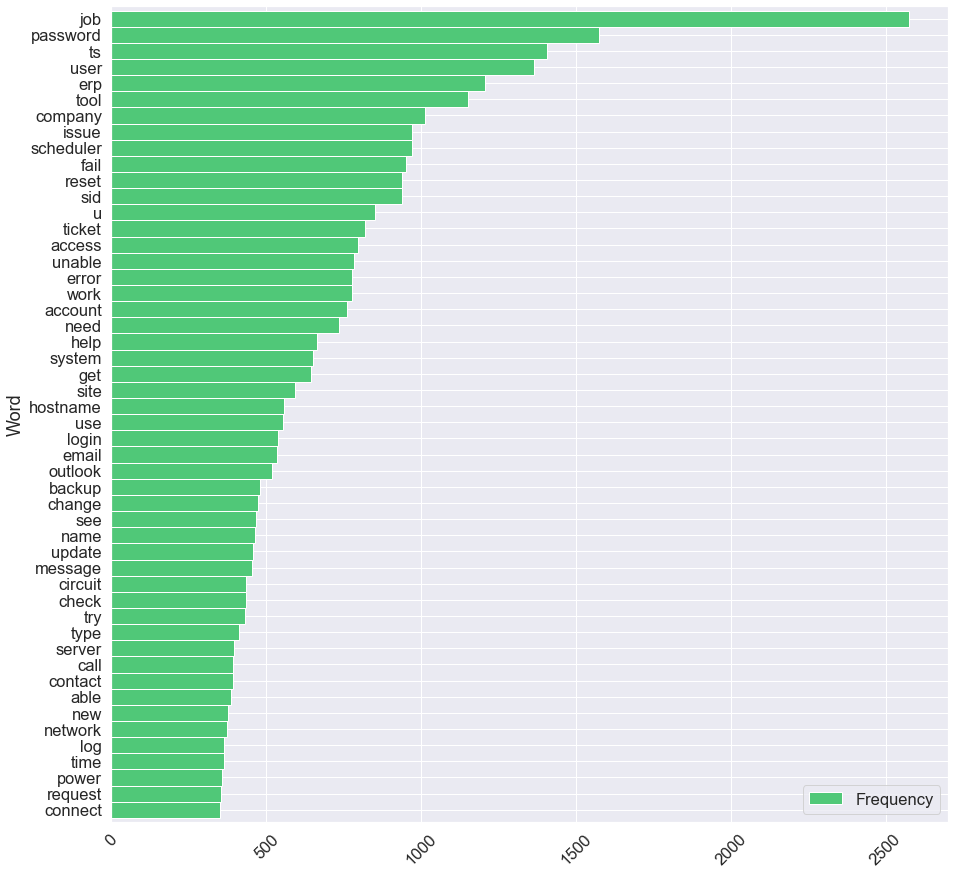

In [144]:
# top 50 most frequent words in text
top_N = 50

words = (merged_dataset.cleaned_description.str.cat(sep=' ').split())
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
rslt[:50].transpose()
sns.set(font_scale=1.5)  # scale up font size
rslt.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=1, figsize=(15, 15), color=config['green_rgb'])
plt.xticks(rotation=45)
plt.savefig('dist_after_cleaning.png')
plt.show()